In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

[5]	cv_agg's res: 0.735306 + 0.0109643
[10]	cv_agg's res: 0.741156 + 0.015558
[15]	cv_agg's res: 0.751478 + 0.00472719
[20]	cv_agg's res: 0.753243 + 0.00636284
[25]	cv_agg's res: 0.754436 + 0.00632555
[30]	cv_agg's res: 0.756123 + 0.0113396
[35]	cv_agg's res: 0.7587 + 0.0131113
[40]	cv_agg's res: 0.759434 + 0.0100026
[45]	cv_agg's res: 0.757216 + 0.0122263
[5]	training's res: 0.888117
[10]	training's res: 0.898508
[15]	training's res: 0.908918
[20]	training's res: 0.914032
[25]	training's res: 0.926242
[30]	training's res: 0.93318
[35]	training's res: 0.94046
[40]	training's res: 0.946315
[45]	training's res: 0.949607
[50]	training's res: 0.958547
[55]	training's res: 0.963728
[60]	training's res: 0.96933
[65]	training's res: 0.974171
[70]	training's res: 0.978545
[75]	training's res: 0.981773
[80]	training's res: 0.984385
[85]	training's res: 0.98808
[90]	training's res: 0.990994
[95]	training's res: 0.993346
[100]	training's res: 0.995448
[105]	training's res: 0.996829
[110]	training

<Figure size 864x1080 with 0 Axes>

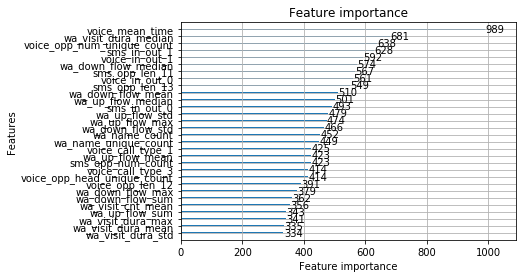

In [6]:
train = pd.read_csv('data/train_featureV1.csv')
test = pd.read_csv('data/test_featureV1.csv')

dtrain = lgb.Dataset(train.drop(['uid','label'],axis=1),label=train.label)
dtest = lgb.Dataset(test.drop(['uid'],axis=1))

lgb_params =  {
    'boosting_type': 'gbdt',
    'objective': 'binary',
     'metric': 'auc',
    'is_training_metric': False,
    'min_data_in_leaf': 12,
    'num_leaves': 64,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'verbosity':-1,
}


def evalMetric(preds,dtrain):
    
    label = dtrain.get_label()
    
    
    pre = pd.DataFrame({'preds':preds,'label':label})
    pre= pre.sort_values(by='preds',ascending=False)
    
    auc = metrics.roc_auc_score(pre.label,pre.preds)

    pre.preds=pre.preds.map(lambda x: 1 if x>=0.5 else 0)

    f1 = metrics.f1_score(pre.label,pre.preds)
    
    
    res = 0.6*auc +0.4*f1
    
    return 'res',res,True

lgb.cv(lgb_params,dtrain,feval=evalMetric,early_stopping_rounds=10,verbose_eval=5,num_boost_round=10000,nfold=3,metrics=['evalMetric'])

model =lgb.train(lgb_params,dtrain,feval=evalMetric,verbose_eval=5,num_boost_round=300,valid_sets=[dtrain])

pred=model.predict(test.drop(['uid'],axis=1))
res =pd.DataFrame({'uid':test.uid,'label':pred})
res=res.sort_values(by='label',ascending=False)
res.label=res.label.map(lambda x: 1 if x>=0.5 else 0)
res.label = res.label.map(lambda x: int(x))

plt.figure(figsize=(12,15))
lgb.plot_importance(model, max_num_features=30)
plt.title("Feature importance")
plt.show()

#res.to_csv('data\lgb-result_b.csv',index=False,header=False,sep=',',columns=['uid','label'])


In [3]:
from sklearn.cross_validation import train_test_split, KFold
dy = train['label']
dx = train.drop(['uid', 'label'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(dx, dy, test_size=0.3, random_state= 1)

lgb_train = lgb.Dataset(X_train,y_train, free_raw_data=False)
lgb_test = lgb.Dataset(X_test,y_test, free_raw_data=False)
print('设置参数')
params = {
    'boosting_type': 'gbdt',
    'boosting': 'dart',
    'objective': 'binary',
    'metric': 'auc',

    'learning_rate': 0.005,
    'num_leaves':250,
    'max_depth':8,

    'max_bin':50,
    'min_data_in_leaf':200,

    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq':0,

    'lambda_l1': 0,
    'lambda_l2': 0,
    'min_split_gain': 0
}
print('交叉验证')
min_merror = float('Inf')
best_params = {}
print("调参1：提高准确率")
for num_leaves in range(20,200,5):
    for max_depth in range(3,8,1):
        params['num_leaves'] = num_leaves
        params['max_depth'] = max_depth

        cv_results = lgb.cv(
                            lgb_params,
                            lgb_train,
                            seed=2018,
                            nfold=3,
                            metrics=['auc'],
                            early_stopping_rounds=10,
                            verbose_eval=True
                            )

        mean_merror = pd.Series(cv_results['auc-mean']).min()
        boost_rounds = pd.Series(cv_results['auc-mean']).argmin()

        if mean_merror < min_merror:
            min_merror = mean_merror
            lgb_params['num_leaves'] = num_leaves
            lgb_params['max_depth'] = max_depth

#params['num_leaves'] = best_params['num_leaves']
#params['max_depth'] = best_params['max_depth']
lgb_params['num_leaves'] = best_params['num_leaves']
lgb_params['max_depth'] = best_params['max_depth']


d:\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


设置参数
交叉验证
调参1：提高准确率
[1]	cv_agg's auc: 0.80574 + 0.0176466
[2]	cv_agg's auc: 0.860656 + 0.00842763
[3]	cv_agg's auc: 0.86899 + 0.00757202
[4]	cv_agg's auc: 0.868993 + 0.00380003
[5]	cv_agg's auc: 0.873024 + 0.00481455
[6]	cv_agg's auc: 0.87628 + 0.00475898
[7]	cv_agg's auc: 0.874792 + 0.00623835
[8]	cv_agg's auc: 0.877288 + 0.00615411
[9]	cv_agg's auc: 0.878286 + 0.00716796
[10]	cv_agg's auc: 0.881131 + 0.00690471
[11]	cv_agg's auc: 0.882648 + 0.00666483
[12]	cv_agg's auc: 0.882865 + 0.00816173
[13]	cv_agg's auc: 0.884242 + 0.00960094
[14]	cv_agg's auc: 0.884294 + 0.00972171
[15]	cv_agg's auc: 0.885778 + 0.0100195
[16]	cv_agg's auc: 0.887167 + 0.00989349
[17]	cv_agg's auc: 0.888252 + 0.0100714
[18]	cv_agg's auc: 0.88845 + 0.0103616
[19]	cv_agg's auc: 0.889428 + 0.0108777
[20]	cv_agg's auc: 0.889691 + 0.00985346
[21]	cv_agg's auc: 0.891162 + 0.00940823
[22]	cv_agg's auc: 0.891192 + 0.00952931
[23]	cv_agg's auc: 0.891603 + 0.00952013
[24]	cv_agg's auc: 0.892335 + 0.00989981
[25]	cv_agg's 

d:\python36\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.



[15]	cv_agg's auc: 0.868464 + 0.0114382
[16]	cv_agg's auc: 0.870774 + 0.011574
[17]	cv_agg's auc: 0.871692 + 0.0131206
[18]	cv_agg's auc: 0.872765 + 0.0128798
[19]	cv_agg's auc: 0.874441 + 0.0124668
[20]	cv_agg's auc: 0.875084 + 0.0112243
[21]	cv_agg's auc: 0.875059 + 0.0108043
[22]	cv_agg's auc: 0.875673 + 0.0100312
[23]	cv_agg's auc: 0.876172 + 0.009159
[24]	cv_agg's auc: 0.876655 + 0.00918157
[25]	cv_agg's auc: 0.877236 + 0.00926558
[26]	cv_agg's auc: 0.878334 + 0.00882641
[27]	cv_agg's auc: 0.878532 + 0.00829642
[28]	cv_agg's auc: 0.878981 + 0.00852808
[29]	cv_agg's auc: 0.878593 + 0.00835958
[30]	cv_agg's auc: 0.87874 + 0.00766275
[31]	cv_agg's auc: 0.878415 + 0.0077947
[32]	cv_agg's auc: 0.87902 + 0.0081535
[33]	cv_agg's auc: 0.879261 + 0.00802975
[34]	cv_agg's auc: 0.879508 + 0.0074806
[35]	cv_agg's auc: 0.880108 + 0.00772446
[36]	cv_agg's auc: 0.88129 + 0.00762764
[37]	cv_agg's auc: 0.881784 + 0.00773308
[38]	cv_agg's auc: 0.882038 + 0.00757952
[39]	cv_agg's auc: 0.882386 + 0.

[41]	cv_agg's auc: 0.894703 + 0.00741934
[42]	cv_agg's auc: 0.894916 + 0.00759765
[43]	cv_agg's auc: 0.894758 + 0.00749465
[44]	cv_agg's auc: 0.894426 + 0.00768171
[45]	cv_agg's auc: 0.89458 + 0.00787203
[46]	cv_agg's auc: 0.894701 + 0.00797903
[47]	cv_agg's auc: 0.895185 + 0.00803765
[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.895301 + 0.00772533
[51]	cv_agg's auc: 0.895361 + 0.00819517
[52]	cv_agg's auc: 0.895774 + 0.00828046
[53]	cv_agg's auc: 0.895831 + 0.00799513
[54]	cv_agg's auc: 0.895975 + 0.00788833
[55]	cv_agg's auc: 0.896454 + 0.00787027
[56]	cv_agg's auc: 0.896927 + 0.008064
[57]	cv_agg's auc: 0.897187 + 0.00802967
[58]	cv_agg's auc: 0.897448 + 0.00806932
[59]	cv_agg's auc: 0.897664 + 0.00793358
[60]	cv_agg's auc: 0.898014 + 0.00783911
[61]	cv_agg's auc: 0.898408 + 0.00766274
[62]	cv_agg's auc: 0.898539 + 0.00761076
[63]	cv_agg's auc: 0.898878 + 0.00756243
[64]	cv_agg's auc: 0.899021 + 0.00781938
[65]	cv_agg's auc: 0

[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.895301 + 0.00772533
[51]	cv_agg's auc: 0.895361 + 0.00819517
[52]	cv_agg's auc: 0.895774 + 0.00828046
[53]	cv_agg's auc: 0.895831 + 0.00799513
[54]	cv_agg's auc: 0.895975 + 0.00788833
[55]	cv_agg's auc: 0.896454 + 0.00787027
[56]	cv_agg's auc: 0.896927 + 0.008064
[57]	cv_agg's auc: 0.897187 + 0.00802967
[58]	cv_agg's auc: 0.897448 + 0.00806932
[59]	cv_agg's auc: 0.897664 + 0.00793358
[60]	cv_agg's auc: 0.898014 + 0.00783911
[61]	cv_agg's auc: 0.898408 + 0.00766274
[62]	cv_agg's auc: 0.898539 + 0.00761076
[63]	cv_agg's auc: 0.898878 + 0.00756243
[64]	cv_agg's auc: 0.899021 + 0.00781938
[65]	cv_agg's auc: 0.899062 + 0.00770136
[66]	cv_agg's auc: 0.899305 + 0.00779291
[67]	cv_agg's auc: 0.899562 + 0.00767323
[68]	cv_agg's auc: 0.899685 + 0.0075999
[69]	cv_agg's auc: 0.899963 + 0.00743449
[70]	cv_agg's auc: 0.900203 + 0.00742557
[71]	cv_agg's auc: 0.900655 + 0.00743061
[72]	cv_agg's auc: 0

[68]	cv_agg's auc: 0.899685 + 0.0075999
[69]	cv_agg's auc: 0.899963 + 0.00743449
[70]	cv_agg's auc: 0.900203 + 0.00742557
[71]	cv_agg's auc: 0.900655 + 0.00743061
[72]	cv_agg's auc: 0.900765 + 0.00707607
[73]	cv_agg's auc: 0.900852 + 0.00694462
[74]	cv_agg's auc: 0.900969 + 0.00696105
[75]	cv_agg's auc: 0.901118 + 0.00702535
[76]	cv_agg's auc: 0.901194 + 0.00714295
[77]	cv_agg's auc: 0.901462 + 0.00722272
[78]	cv_agg's auc: 0.901462 + 0.00699896
[79]	cv_agg's auc: 0.901616 + 0.0069986
[80]	cv_agg's auc: 0.901698 + 0.00674349
[81]	cv_agg's auc: 0.901884 + 0.0069575
[82]	cv_agg's auc: 0.90207 + 0.00653834
[83]	cv_agg's auc: 0.902334 + 0.00658974
[84]	cv_agg's auc: 0.902493 + 0.00652871
[85]	cv_agg's auc: 0.902639 + 0.00618373
[86]	cv_agg's auc: 0.902733 + 0.00613884
[87]	cv_agg's auc: 0.903072 + 0.00619057
[88]	cv_agg's auc: 0.903482 + 0.00599074
[89]	cv_agg's auc: 0.903553 + 0.00590616
[90]	cv_agg's auc: 0.903677 + 0.00600126
[91]	cv_agg's auc: 0.903595 + 0.00593829
[92]	cv_agg's auc: 0

[72]	cv_agg's auc: 0.900765 + 0.00707607
[73]	cv_agg's auc: 0.900852 + 0.00694462
[74]	cv_agg's auc: 0.900969 + 0.00696105
[75]	cv_agg's auc: 0.901118 + 0.00702535
[76]	cv_agg's auc: 0.901194 + 0.00714295
[77]	cv_agg's auc: 0.901462 + 0.00722272
[78]	cv_agg's auc: 0.901462 + 0.00699896
[79]	cv_agg's auc: 0.901616 + 0.0069986
[80]	cv_agg's auc: 0.901698 + 0.00674349
[81]	cv_agg's auc: 0.901884 + 0.0069575
[82]	cv_agg's auc: 0.90207 + 0.00653834
[83]	cv_agg's auc: 0.902334 + 0.00658974
[84]	cv_agg's auc: 0.902493 + 0.00652871
[85]	cv_agg's auc: 0.902639 + 0.00618373
[86]	cv_agg's auc: 0.902733 + 0.00613884
[87]	cv_agg's auc: 0.903072 + 0.00619057
[88]	cv_agg's auc: 0.903482 + 0.00599074
[89]	cv_agg's auc: 0.903553 + 0.00590616
[90]	cv_agg's auc: 0.903677 + 0.00600126
[91]	cv_agg's auc: 0.903595 + 0.00593829
[92]	cv_agg's auc: 0.903868 + 0.00591334
[93]	cv_agg's auc: 0.904443 + 0.00581341
[94]	cv_agg's auc: 0.904466 + 0.00584093
[95]	cv_agg's auc: 0.9045 + 0.00582425
[96]	cv_agg's auc: 0.

[2]	cv_agg's auc: 0.86498 + 0.00687368
[3]	cv_agg's auc: 0.868276 + 0.00489329
[4]	cv_agg's auc: 0.871848 + 0.00735517
[5]	cv_agg's auc: 0.876787 + 0.00688823
[6]	cv_agg's auc: 0.876141 + 0.00705509
[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217 + 0.00868749
[9]	cv_agg's auc: 0.878974 + 0.00829956
[10]	cv_agg's auc: 0.880629 + 0.00771552
[11]	cv_agg's auc: 0.880938 + 0.00653289
[12]	cv_agg's auc: 0.88307 + 0.00765083
[13]	cv_agg's auc: 0.883797 + 0.00830503
[14]	cv_agg's auc: 0.88268 + 0.00823014
[15]	cv_agg's auc: 0.883713 + 0.00769711
[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 + 0.00760788
[25]	cv_agg's auc: 0.890462 + 0.0077697
[26]	cv_agg's auc: 0.890672 + 

[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217 + 0.00868749
[9]	cv_agg's auc: 0.878974 + 0.00829956
[10]	cv_agg's auc: 0.880629 + 0.00771552
[11]	cv_agg's auc: 0.880938 + 0.00653289
[12]	cv_agg's auc: 0.88307 + 0.00765083
[13]	cv_agg's auc: 0.883797 + 0.00830503
[14]	cv_agg's auc: 0.88268 + 0.00823014
[15]	cv_agg's auc: 0.883713 + 0.00769711
[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 + 0.00760788
[25]	cv_agg's auc: 0.890462 + 0.0077697
[26]	cv_agg's auc: 0.890672 + 0.00770596
[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512 + 0.00648787
[31]	cv_agg's auc: 0.89263

[15]	cv_agg's auc: 0.883713 + 0.00769711
[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 + 0.00760788
[25]	cv_agg's auc: 0.890462 + 0.0077697
[26]	cv_agg's auc: 0.890672 + 0.00770596
[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512 + 0.00648787
[31]	cv_agg's auc: 0.892638 + 0.00687136
[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892823 + 0.00623328
[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.8

[26]	cv_agg's auc: 0.890672 + 0.00770596
[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512 + 0.00648787
[31]	cv_agg's auc: 0.892638 + 0.00687136
[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892823 + 0.00623328
[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.894582 + 0.0073721
[41]	cv_agg's auc: 0.894703 + 0.00741934
[42]	cv_agg's auc: 0.894916 + 0.00759765
[43]	cv_agg's auc: 0.894758 + 0.00749465
[44]	cv_agg's auc: 0.894426 + 0.00768171
[45]	cv_agg's auc: 0.89458 + 0.00787203
[46]	cv_agg's auc: 0.894701 + 0.00797903
[47]	cv_agg's auc: 0.895185 + 0.00803765
[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.8

[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.894582 + 0.0073721
[41]	cv_agg's auc: 0.894703 + 0.00741934
[42]	cv_agg's auc: 0.894916 + 0.00759765
[43]	cv_agg's auc: 0.894758 + 0.00749465
[44]	cv_agg's auc: 0.894426 + 0.00768171
[45]	cv_agg's auc: 0.89458 + 0.00787203
[46]	cv_agg's auc: 0.894701 + 0.00797903
[47]	cv_agg's auc: 0.895185 + 0.00803765
[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.895301 + 0.00772533
[51]	cv_agg's auc: 0.895361 + 0.00819517
[52]	cv_agg's auc: 0.895774 + 0.00828046
[53]	cv_agg's auc: 0.895831 + 0.00799513
[54]	cv_agg's auc: 0.895975 + 0.00788833
[55]	cv_agg's auc: 0.896454 + 0.00787027
[56]	cv_agg's auc: 0.896927 + 0.008064
[57]	cv_agg's auc: 0.897187 + 0.00802967
[58]	cv_agg's auc: 0.897448 + 0.00806932
[59]	cv_agg's auc: 0.897664 + 0.00793358
[60]	cv_agg's auc: 0.898014 + 0.00783911
[61]	cv_agg's auc: 0.

[60]	cv_agg's auc: 0.898014 + 0.00783911
[61]	cv_agg's auc: 0.898408 + 0.00766274
[62]	cv_agg's auc: 0.898539 + 0.00761076
[63]	cv_agg's auc: 0.898878 + 0.00756243
[64]	cv_agg's auc: 0.899021 + 0.00781938
[65]	cv_agg's auc: 0.899062 + 0.00770136
[66]	cv_agg's auc: 0.899305 + 0.00779291
[67]	cv_agg's auc: 0.899562 + 0.00767323
[68]	cv_agg's auc: 0.899685 + 0.0075999
[69]	cv_agg's auc: 0.899963 + 0.00743449
[70]	cv_agg's auc: 0.900203 + 0.00742557
[71]	cv_agg's auc: 0.900655 + 0.00743061
[72]	cv_agg's auc: 0.900765 + 0.00707607
[73]	cv_agg's auc: 0.900852 + 0.00694462
[74]	cv_agg's auc: 0.900969 + 0.00696105
[75]	cv_agg's auc: 0.901118 + 0.00702535
[76]	cv_agg's auc: 0.901194 + 0.00714295
[77]	cv_agg's auc: 0.901462 + 0.00722272
[78]	cv_agg's auc: 0.901462 + 0.00699896
[79]	cv_agg's auc: 0.901616 + 0.0069986
[80]	cv_agg's auc: 0.901698 + 0.00674349
[81]	cv_agg's auc: 0.901884 + 0.0069575
[82]	cv_agg's auc: 0.90207 + 0.00653834
[83]	cv_agg's auc: 0.902334 + 0.00658974
[84]	cv_agg's auc: 0

[86]	cv_agg's auc: 0.902733 + 0.00613884
[87]	cv_agg's auc: 0.903072 + 0.00619057
[88]	cv_agg's auc: 0.903482 + 0.00599074
[89]	cv_agg's auc: 0.903553 + 0.00590616
[90]	cv_agg's auc: 0.903677 + 0.00600126
[91]	cv_agg's auc: 0.903595 + 0.00593829
[92]	cv_agg's auc: 0.903868 + 0.00591334
[93]	cv_agg's auc: 0.904443 + 0.00581341
[94]	cv_agg's auc: 0.904466 + 0.00584093
[95]	cv_agg's auc: 0.9045 + 0.00582425
[96]	cv_agg's auc: 0.90498 + 0.00597003
[97]	cv_agg's auc: 0.905235 + 0.00569572
[98]	cv_agg's auc: 0.905376 + 0.00574889
[99]	cv_agg's auc: 0.905457 + 0.00586074
[100]	cv_agg's auc: 0.905402 + 0.00594236
[1]	cv_agg's auc: 0.823685 + 0.00610245
[2]	cv_agg's auc: 0.86498 + 0.00687368
[3]	cv_agg's auc: 0.868276 + 0.00489329
[4]	cv_agg's auc: 0.871848 + 0.00735517
[5]	cv_agg's auc: 0.876787 + 0.00688823
[6]	cv_agg's auc: 0.876141 + 0.00705509
[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217 + 0.00868749
[9]	cv_agg's auc: 0.878974 + 0.00829956
[10]	cv_agg's auc: 0.880629 

[89]	cv_agg's auc: 0.903553 + 0.00590616
[90]	cv_agg's auc: 0.903677 + 0.00600126
[91]	cv_agg's auc: 0.903595 + 0.00593829
[92]	cv_agg's auc: 0.903868 + 0.00591334
[93]	cv_agg's auc: 0.904443 + 0.00581341
[94]	cv_agg's auc: 0.904466 + 0.00584093
[95]	cv_agg's auc: 0.9045 + 0.00582425
[96]	cv_agg's auc: 0.90498 + 0.00597003
[97]	cv_agg's auc: 0.905235 + 0.00569572
[98]	cv_agg's auc: 0.905376 + 0.00574889
[99]	cv_agg's auc: 0.905457 + 0.00586074
[100]	cv_agg's auc: 0.905402 + 0.00594236
[1]	cv_agg's auc: 0.823685 + 0.00610245
[2]	cv_agg's auc: 0.86498 + 0.00687368
[3]	cv_agg's auc: 0.868276 + 0.00489329
[4]	cv_agg's auc: 0.871848 + 0.00735517
[5]	cv_agg's auc: 0.876787 + 0.00688823
[6]	cv_agg's auc: 0.876141 + 0.00705509
[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217 + 0.00868749
[9]	cv_agg's auc: 0.878974 + 0.00829956
[10]	cv_agg's auc: 0.880629 + 0.00771552
[11]	cv_agg's auc: 0.880938 + 0.00653289
[12]	cv_agg's auc: 0.88307 + 0.00765083
[13]	cv_agg's auc: 0.883797 +

[94]	cv_agg's auc: 0.904466 + 0.00584093
[95]	cv_agg's auc: 0.9045 + 0.00582425
[96]	cv_agg's auc: 0.90498 + 0.00597003
[97]	cv_agg's auc: 0.905235 + 0.00569572
[98]	cv_agg's auc: 0.905376 + 0.00574889
[99]	cv_agg's auc: 0.905457 + 0.00586074
[100]	cv_agg's auc: 0.905402 + 0.00594236
[1]	cv_agg's auc: 0.823685 + 0.00610245
[2]	cv_agg's auc: 0.86498 + 0.00687368
[3]	cv_agg's auc: 0.868276 + 0.00489329
[4]	cv_agg's auc: 0.871848 + 0.00735517
[5]	cv_agg's auc: 0.876787 + 0.00688823
[6]	cv_agg's auc: 0.876141 + 0.00705509
[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217 + 0.00868749
[9]	cv_agg's auc: 0.878974 + 0.00829956
[10]	cv_agg's auc: 0.880629 + 0.00771552
[11]	cv_agg's auc: 0.880938 + 0.00653289
[12]	cv_agg's auc: 0.88307 + 0.00765083
[13]	cv_agg's auc: 0.883797 + 0.00830503
[14]	cv_agg's auc: 0.88268 + 0.00823014
[15]	cv_agg's auc: 0.883713 + 0.00769711
[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0

[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217 + 0.00868749
[9]	cv_agg's auc: 0.878974 + 0.00829956
[10]	cv_agg's auc: 0.880629 + 0.00771552
[11]	cv_agg's auc: 0.880938 + 0.00653289
[12]	cv_agg's auc: 0.88307 + 0.00765083
[13]	cv_agg's auc: 0.883797 + 0.00830503
[14]	cv_agg's auc: 0.88268 + 0.00823014
[15]	cv_agg's auc: 0.883713 + 0.00769711
[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 + 0.00760788
[25]	cv_agg's auc: 0.890462 + 0.0077697
[26]	cv_agg's auc: 0.890672 + 0.00770596
[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512 + 0.00648787
[31]	cv_agg's auc: 0.89263

[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 + 0.00760788
[25]	cv_agg's auc: 0.890462 + 0.0077697
[26]	cv_agg's auc: 0.890672 + 0.00770596
[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512 + 0.00648787
[31]	cv_agg's auc: 0.892638 + 0.00687136
[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892823 + 0.00623328
[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.8

[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.894582 + 0.0073721
[41]	cv_agg's auc: 0.894703 + 0.00741934
[42]	cv_agg's auc: 0.894916 + 0.00759765
[43]	cv_agg's auc: 0.894758 + 0.00749465
[44]	cv_agg's auc: 0.894426 + 0.00768171
[45]	cv_agg's auc: 0.89458 + 0.00787203
[46]	cv_agg's auc: 0.894701 + 0.00797903
[47]	cv_agg's auc: 0.895185 + 0.00803765
[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.895301 + 0.00772533
[51]	cv_agg's auc: 0.895361 + 0.00819517
[52]	cv_agg's auc: 0.895774 + 0.00828046
[53]	cv_agg's auc: 0.895831 + 0.00799513
[54]	cv_agg's auc: 0.895975 + 0.00788833
[55]	cv_agg's auc: 0.896454 + 0.00787027
[56]	cv_agg's auc: 0.896927 + 0.008064
[57]	cv_agg's auc: 0.897187 + 0.00802967
[58]	cv_agg's auc: 0.897448 + 0.00806932
[59]	cv_agg's auc: 0.

[55]	cv_agg's auc: 0.896454 + 0.00787027
[56]	cv_agg's auc: 0.896927 + 0.008064
[57]	cv_agg's auc: 0.897187 + 0.00802967
[58]	cv_agg's auc: 0.897448 + 0.00806932
[59]	cv_agg's auc: 0.897664 + 0.00793358
[60]	cv_agg's auc: 0.898014 + 0.00783911
[61]	cv_agg's auc: 0.898408 + 0.00766274
[62]	cv_agg's auc: 0.898539 + 0.00761076
[63]	cv_agg's auc: 0.898878 + 0.00756243
[64]	cv_agg's auc: 0.899021 + 0.00781938
[65]	cv_agg's auc: 0.899062 + 0.00770136
[66]	cv_agg's auc: 0.899305 + 0.00779291
[67]	cv_agg's auc: 0.899562 + 0.00767323
[68]	cv_agg's auc: 0.899685 + 0.0075999
[69]	cv_agg's auc: 0.899963 + 0.00743449
[70]	cv_agg's auc: 0.900203 + 0.00742557
[71]	cv_agg's auc: 0.900655 + 0.00743061
[72]	cv_agg's auc: 0.900765 + 0.00707607
[73]	cv_agg's auc: 0.900852 + 0.00694462
[74]	cv_agg's auc: 0.900969 + 0.00696105
[75]	cv_agg's auc: 0.901118 + 0.00702535
[76]	cv_agg's auc: 0.901194 + 0.00714295
[77]	cv_agg's auc: 0.901462 + 0.00722272
[78]	cv_agg's auc: 0.901462 + 0.00699896
[79]	cv_agg's auc: 

[81]	cv_agg's auc: 0.901884 + 0.0069575
[82]	cv_agg's auc: 0.90207 + 0.00653834
[83]	cv_agg's auc: 0.902334 + 0.00658974
[84]	cv_agg's auc: 0.902493 + 0.00652871
[85]	cv_agg's auc: 0.902639 + 0.00618373
[86]	cv_agg's auc: 0.902733 + 0.00613884
[87]	cv_agg's auc: 0.903072 + 0.00619057
[88]	cv_agg's auc: 0.903482 + 0.00599074
[89]	cv_agg's auc: 0.903553 + 0.00590616
[90]	cv_agg's auc: 0.903677 + 0.00600126
[91]	cv_agg's auc: 0.903595 + 0.00593829
[92]	cv_agg's auc: 0.903868 + 0.00591334
[93]	cv_agg's auc: 0.904443 + 0.00581341
[94]	cv_agg's auc: 0.904466 + 0.00584093
[95]	cv_agg's auc: 0.9045 + 0.00582425
[96]	cv_agg's auc: 0.90498 + 0.00597003
[97]	cv_agg's auc: 0.905235 + 0.00569572
[98]	cv_agg's auc: 0.905376 + 0.00574889
[99]	cv_agg's auc: 0.905457 + 0.00586074
[100]	cv_agg's auc: 0.905402 + 0.00594236
[1]	cv_agg's auc: 0.823685 + 0.00610245
[2]	cv_agg's auc: 0.86498 + 0.00687368
[3]	cv_agg's auc: 0.868276 + 0.00489329
[4]	cv_agg's auc: 0.871848 + 0.00735517
[5]	cv_agg's auc: 0.87678

[100]	cv_agg's auc: 0.905402 + 0.00594236
[1]	cv_agg's auc: 0.823685 + 0.00610245
[2]	cv_agg's auc: 0.86498 + 0.00687368
[3]	cv_agg's auc: 0.868276 + 0.00489329
[4]	cv_agg's auc: 0.871848 + 0.00735517
[5]	cv_agg's auc: 0.876787 + 0.00688823
[6]	cv_agg's auc: 0.876141 + 0.00705509
[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217 + 0.00868749
[9]	cv_agg's auc: 0.878974 + 0.00829956
[10]	cv_agg's auc: 0.880629 + 0.00771552
[11]	cv_agg's auc: 0.880938 + 0.00653289
[12]	cv_agg's auc: 0.88307 + 0.00765083
[13]	cv_agg's auc: 0.883797 + 0.00830503
[14]	cv_agg's auc: 0.88268 + 0.00823014
[15]	cv_agg's auc: 0.883713 + 0.00769711
[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 +

[10]	cv_agg's auc: 0.880629 + 0.00771552
[11]	cv_agg's auc: 0.880938 + 0.00653289
[12]	cv_agg's auc: 0.88307 + 0.00765083
[13]	cv_agg's auc: 0.883797 + 0.00830503
[14]	cv_agg's auc: 0.88268 + 0.00823014
[15]	cv_agg's auc: 0.883713 + 0.00769711
[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 + 0.00760788
[25]	cv_agg's auc: 0.890462 + 0.0077697
[26]	cv_agg's auc: 0.890672 + 0.00770596
[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512 + 0.00648787
[31]	cv_agg's auc: 0.892638 + 0.00687136
[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892

[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892823 + 0.00623328
[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.894582 + 0.0073721
[41]	cv_agg's auc: 0.894703 + 0.00741934
[42]	cv_agg's auc: 0.894916 + 0.00759765
[43]	cv_agg's auc: 0.894758 + 0.00749465
[44]	cv_agg's auc: 0.894426 + 0.00768171
[45]	cv_agg's auc: 0.89458 + 0.00787203
[46]	cv_agg's auc: 0.894701 + 0.00797903
[47]	cv_agg's auc: 0.895185 + 0.00803765
[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.895301 + 0.00772533
[51]	cv_agg's auc: 0.895361 + 0.00819517
[52]	cv_agg's auc: 0.895774 + 0.00828046
[53]	cv_agg's auc: 0.895831 + 0.00799513
[54]	cv_agg's auc: 0.895975 + 0.00788833
[55]	cv_agg's auc: 0.896454 + 0.00787027
[56]	cv_agg's auc: 0

[63]	cv_agg's auc: 0.898878 + 0.00756243
[64]	cv_agg's auc: 0.899021 + 0.00781938
[65]	cv_agg's auc: 0.899062 + 0.00770136
[66]	cv_agg's auc: 0.899305 + 0.00779291
[67]	cv_agg's auc: 0.899562 + 0.00767323
[68]	cv_agg's auc: 0.899685 + 0.0075999
[69]	cv_agg's auc: 0.899963 + 0.00743449
[70]	cv_agg's auc: 0.900203 + 0.00742557
[71]	cv_agg's auc: 0.900655 + 0.00743061
[72]	cv_agg's auc: 0.900765 + 0.00707607
[73]	cv_agg's auc: 0.900852 + 0.00694462
[74]	cv_agg's auc: 0.900969 + 0.00696105
[75]	cv_agg's auc: 0.901118 + 0.00702535
[76]	cv_agg's auc: 0.901194 + 0.00714295
[77]	cv_agg's auc: 0.901462 + 0.00722272
[78]	cv_agg's auc: 0.901462 + 0.00699896
[79]	cv_agg's auc: 0.901616 + 0.0069986
[80]	cv_agg's auc: 0.901698 + 0.00674349
[81]	cv_agg's auc: 0.901884 + 0.0069575
[82]	cv_agg's auc: 0.90207 + 0.00653834
[83]	cv_agg's auc: 0.902334 + 0.00658974
[84]	cv_agg's auc: 0.902493 + 0.00652871
[85]	cv_agg's auc: 0.902639 + 0.00618373
[86]	cv_agg's auc: 0.902733 + 0.00613884
[87]	cv_agg's auc: 0

[91]	cv_agg's auc: 0.903595 + 0.00593829
[92]	cv_agg's auc: 0.903868 + 0.00591334
[93]	cv_agg's auc: 0.904443 + 0.00581341
[94]	cv_agg's auc: 0.904466 + 0.00584093
[95]	cv_agg's auc: 0.9045 + 0.00582425
[96]	cv_agg's auc: 0.90498 + 0.00597003
[97]	cv_agg's auc: 0.905235 + 0.00569572
[98]	cv_agg's auc: 0.905376 + 0.00574889
[99]	cv_agg's auc: 0.905457 + 0.00586074
[100]	cv_agg's auc: 0.905402 + 0.00594236
[1]	cv_agg's auc: 0.823685 + 0.00610245
[2]	cv_agg's auc: 0.86498 + 0.00687368
[3]	cv_agg's auc: 0.868276 + 0.00489329
[4]	cv_agg's auc: 0.871848 + 0.00735517
[5]	cv_agg's auc: 0.876787 + 0.00688823
[6]	cv_agg's auc: 0.876141 + 0.00705509
[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217 + 0.00868749
[9]	cv_agg's auc: 0.878974 + 0.00829956
[10]	cv_agg's auc: 0.880629 + 0.00771552
[11]	cv_agg's auc: 0.880938 + 0.00653289
[12]	cv_agg's auc: 0.88307 + 0.00765083
[13]	cv_agg's auc: 0.883797 + 0.00830503
[14]	cv_agg's auc: 0.88268 + 0.00823014
[15]	cv_agg's auc: 0.883713 + 

[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 + 0.00760788
[25]	cv_agg's auc: 0.890462 + 0.0077697
[26]	cv_agg's auc: 0.890672 + 0.00770596
[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512 + 0.00648787
[31]	cv_agg's auc: 0.892638 + 0.00687136
[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892823 + 0.00623328
[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.894582 + 0.0073721
[41]	cv_agg's auc: 0.8

[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.894582 + 0.0073721
[41]	cv_agg's auc: 0.894703 + 0.00741934
[42]	cv_agg's auc: 0.894916 + 0.00759765
[43]	cv_agg's auc: 0.894758 + 0.00749465
[44]	cv_agg's auc: 0.894426 + 0.00768171
[45]	cv_agg's auc: 0.89458 + 0.00787203
[46]	cv_agg's auc: 0.894701 + 0.00797903
[47]	cv_agg's auc: 0.895185 + 0.00803765
[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.895301 + 0.00772533
[51]	cv_agg's auc: 0.895361 + 0.00819517
[52]	cv_agg's auc: 0.895774 + 0.00828046
[53]	cv_agg's auc: 0.895831 + 0.00799513
[54]	cv_agg's auc: 0.895975 + 0.00788833
[55]	cv_agg's auc: 0.896454 + 0.00787027
[56]	cv_agg's auc: 0.896927 + 0.008064
[57]	cv_agg's auc: 0.897187 + 0.00802967
[58]	cv_agg's auc: 0.897448 + 0.00806932
[59]	cv_agg's auc: 0.897664 + 0.00793358
[60]	cv_agg's auc: 0.898014 + 0.00783911
[61]	cv_agg's auc: 0.898408 + 0.00766274
[62]	cv_agg's auc: 0.

[47]	cv_agg's auc: 0.895185 + 0.00803765
[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.895301 + 0.00772533
[51]	cv_agg's auc: 0.895361 + 0.00819517
[52]	cv_agg's auc: 0.895774 + 0.00828046
[53]	cv_agg's auc: 0.895831 + 0.00799513
[54]	cv_agg's auc: 0.895975 + 0.00788833
[55]	cv_agg's auc: 0.896454 + 0.00787027
[56]	cv_agg's auc: 0.896927 + 0.008064
[57]	cv_agg's auc: 0.897187 + 0.00802967
[58]	cv_agg's auc: 0.897448 + 0.00806932
[59]	cv_agg's auc: 0.897664 + 0.00793358
[60]	cv_agg's auc: 0.898014 + 0.00783911
[61]	cv_agg's auc: 0.898408 + 0.00766274
[62]	cv_agg's auc: 0.898539 + 0.00761076
[63]	cv_agg's auc: 0.898878 + 0.00756243
[64]	cv_agg's auc: 0.899021 + 0.00781938
[65]	cv_agg's auc: 0.899062 + 0.00770136
[66]	cv_agg's auc: 0.899305 + 0.00779291
[67]	cv_agg's auc: 0.899562 + 0.00767323
[68]	cv_agg's auc: 0.899685 + 0.0075999
[69]	cv_agg's auc: 0.899963 + 0.00743449
[70]	cv_agg's auc: 0.900203 + 0.00742557
[71]	cv_agg's auc: 0

[52]	cv_agg's auc: 0.895774 + 0.00828046
[53]	cv_agg's auc: 0.895831 + 0.00799513
[54]	cv_agg's auc: 0.895975 + 0.00788833
[55]	cv_agg's auc: 0.896454 + 0.00787027
[56]	cv_agg's auc: 0.896927 + 0.008064
[57]	cv_agg's auc: 0.897187 + 0.00802967
[58]	cv_agg's auc: 0.897448 + 0.00806932
[59]	cv_agg's auc: 0.897664 + 0.00793358
[60]	cv_agg's auc: 0.898014 + 0.00783911
[61]	cv_agg's auc: 0.898408 + 0.00766274
[62]	cv_agg's auc: 0.898539 + 0.00761076
[63]	cv_agg's auc: 0.898878 + 0.00756243
[64]	cv_agg's auc: 0.899021 + 0.00781938
[65]	cv_agg's auc: 0.899062 + 0.00770136
[66]	cv_agg's auc: 0.899305 + 0.00779291
[67]	cv_agg's auc: 0.899562 + 0.00767323
[68]	cv_agg's auc: 0.899685 + 0.0075999
[69]	cv_agg's auc: 0.899963 + 0.00743449
[70]	cv_agg's auc: 0.900203 + 0.00742557
[71]	cv_agg's auc: 0.900655 + 0.00743061
[72]	cv_agg's auc: 0.900765 + 0.00707607
[73]	cv_agg's auc: 0.900852 + 0.00694462
[74]	cv_agg's auc: 0.900969 + 0.00696105
[75]	cv_agg's auc: 0.901118 + 0.00702535
[76]	cv_agg's auc: 

[81]	cv_agg's auc: 0.901884 + 0.0069575
[82]	cv_agg's auc: 0.90207 + 0.00653834
[83]	cv_agg's auc: 0.902334 + 0.00658974
[84]	cv_agg's auc: 0.902493 + 0.00652871
[85]	cv_agg's auc: 0.902639 + 0.00618373
[86]	cv_agg's auc: 0.902733 + 0.00613884
[87]	cv_agg's auc: 0.903072 + 0.00619057
[88]	cv_agg's auc: 0.903482 + 0.00599074
[89]	cv_agg's auc: 0.903553 + 0.00590616
[90]	cv_agg's auc: 0.903677 + 0.00600126
[91]	cv_agg's auc: 0.903595 + 0.00593829
[92]	cv_agg's auc: 0.903868 + 0.00591334
[93]	cv_agg's auc: 0.904443 + 0.00581341
[94]	cv_agg's auc: 0.904466 + 0.00584093
[95]	cv_agg's auc: 0.9045 + 0.00582425
[96]	cv_agg's auc: 0.90498 + 0.00597003
[97]	cv_agg's auc: 0.905235 + 0.00569572
[98]	cv_agg's auc: 0.905376 + 0.00574889
[99]	cv_agg's auc: 0.905457 + 0.00586074
[100]	cv_agg's auc: 0.905402 + 0.00594236
[1]	cv_agg's auc: 0.823685 + 0.00610245
[2]	cv_agg's auc: 0.86498 + 0.00687368
[3]	cv_agg's auc: 0.868276 + 0.00489329
[4]	cv_agg's auc: 0.871848 + 0.00735517
[5]	cv_agg's auc: 0.87678

[2]	cv_agg's auc: 0.86498 + 0.00687368
[3]	cv_agg's auc: 0.868276 + 0.00489329
[4]	cv_agg's auc: 0.871848 + 0.00735517
[5]	cv_agg's auc: 0.876787 + 0.00688823
[6]	cv_agg's auc: 0.876141 + 0.00705509
[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217 + 0.00868749
[9]	cv_agg's auc: 0.878974 + 0.00829956
[10]	cv_agg's auc: 0.880629 + 0.00771552
[11]	cv_agg's auc: 0.880938 + 0.00653289
[12]	cv_agg's auc: 0.88307 + 0.00765083
[13]	cv_agg's auc: 0.883797 + 0.00830503
[14]	cv_agg's auc: 0.88268 + 0.00823014
[15]	cv_agg's auc: 0.883713 + 0.00769711
[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 + 0.00760788
[25]	cv_agg's auc: 0.890462 + 0.0077697
[26]	cv_agg's auc: 0.890672 + 

[25]	cv_agg's auc: 0.890462 + 0.0077697
[26]	cv_agg's auc: 0.890672 + 0.00770596
[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512 + 0.00648787
[31]	cv_agg's auc: 0.892638 + 0.00687136
[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892823 + 0.00623328
[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.894582 + 0.0073721
[41]	cv_agg's auc: 0.894703 + 0.00741934
[42]	cv_agg's auc: 0.894916 + 0.00759765
[43]	cv_agg's auc: 0.894758 + 0.00749465
[44]	cv_agg's auc: 0.894426 + 0.00768171
[45]	cv_agg's auc: 0.89458 + 0.00787203
[46]	cv_agg's auc: 0.894701 + 0.00797903
[47]	cv_agg's auc: 0.895185 + 0.00803765
[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.8

[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.895301 + 0.00772533
[51]	cv_agg's auc: 0.895361 + 0.00819517
[52]	cv_agg's auc: 0.895774 + 0.00828046
[53]	cv_agg's auc: 0.895831 + 0.00799513
[54]	cv_agg's auc: 0.895975 + 0.00788833
[55]	cv_agg's auc: 0.896454 + 0.00787027
[56]	cv_agg's auc: 0.896927 + 0.008064
[57]	cv_agg's auc: 0.897187 + 0.00802967
[58]	cv_agg's auc: 0.897448 + 0.00806932
[59]	cv_agg's auc: 0.897664 + 0.00793358
[60]	cv_agg's auc: 0.898014 + 0.00783911
[61]	cv_agg's auc: 0.898408 + 0.00766274
[62]	cv_agg's auc: 0.898539 + 0.00761076
[63]	cv_agg's auc: 0.898878 + 0.00756243
[64]	cv_agg's auc: 0.899021 + 0.00781938
[65]	cv_agg's auc: 0.899062 + 0.00770136
[66]	cv_agg's auc: 0.899305 + 0.00779291
[67]	cv_agg's auc: 0.899562 + 0.00767323
[68]	cv_agg's auc: 0.899685 + 0.0075999
[69]	cv_agg's auc: 0.899963 + 0.00743449
[70]	cv_agg's auc: 0.900203 + 0.00742557
[71]	cv_agg's auc: 0.900655 + 0.00743061
[72]	cv_agg's auc: 0.900765 + 0.00707607
[73]	cv_agg's auc: 0

[72]	cv_agg's auc: 0.900765 + 0.00707607
[73]	cv_agg's auc: 0.900852 + 0.00694462
[74]	cv_agg's auc: 0.900969 + 0.00696105
[75]	cv_agg's auc: 0.901118 + 0.00702535
[76]	cv_agg's auc: 0.901194 + 0.00714295
[77]	cv_agg's auc: 0.901462 + 0.00722272
[78]	cv_agg's auc: 0.901462 + 0.00699896
[79]	cv_agg's auc: 0.901616 + 0.0069986
[80]	cv_agg's auc: 0.901698 + 0.00674349
[81]	cv_agg's auc: 0.901884 + 0.0069575
[82]	cv_agg's auc: 0.90207 + 0.00653834
[83]	cv_agg's auc: 0.902334 + 0.00658974
[84]	cv_agg's auc: 0.902493 + 0.00652871
[85]	cv_agg's auc: 0.902639 + 0.00618373
[86]	cv_agg's auc: 0.902733 + 0.00613884
[87]	cv_agg's auc: 0.903072 + 0.00619057
[88]	cv_agg's auc: 0.903482 + 0.00599074
[89]	cv_agg's auc: 0.903553 + 0.00590616
[90]	cv_agg's auc: 0.903677 + 0.00600126
[91]	cv_agg's auc: 0.903595 + 0.00593829
[92]	cv_agg's auc: 0.903868 + 0.00591334
[93]	cv_agg's auc: 0.904443 + 0.00581341
[94]	cv_agg's auc: 0.904466 + 0.00584093
[95]	cv_agg's auc: 0.9045 + 0.00582425
[96]	cv_agg's auc: 0.

[85]	cv_agg's auc: 0.902639 + 0.00618373
[86]	cv_agg's auc: 0.902733 + 0.00613884
[87]	cv_agg's auc: 0.903072 + 0.00619057
[88]	cv_agg's auc: 0.903482 + 0.00599074
[89]	cv_agg's auc: 0.903553 + 0.00590616
[90]	cv_agg's auc: 0.903677 + 0.00600126
[91]	cv_agg's auc: 0.903595 + 0.00593829
[92]	cv_agg's auc: 0.903868 + 0.00591334
[93]	cv_agg's auc: 0.904443 + 0.00581341
[94]	cv_agg's auc: 0.904466 + 0.00584093
[95]	cv_agg's auc: 0.9045 + 0.00582425
[96]	cv_agg's auc: 0.90498 + 0.00597003
[97]	cv_agg's auc: 0.905235 + 0.00569572
[98]	cv_agg's auc: 0.905376 + 0.00574889
[99]	cv_agg's auc: 0.905457 + 0.00586074
[100]	cv_agg's auc: 0.905402 + 0.00594236
[1]	cv_agg's auc: 0.823685 + 0.00610245
[2]	cv_agg's auc: 0.86498 + 0.00687368
[3]	cv_agg's auc: 0.868276 + 0.00489329
[4]	cv_agg's auc: 0.871848 + 0.00735517
[5]	cv_agg's auc: 0.876787 + 0.00688823
[6]	cv_agg's auc: 0.876141 + 0.00705509
[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217 + 0.00868749
[9]	cv_agg's auc: 0.878974 

[98]	cv_agg's auc: 0.905376 + 0.00574889
[99]	cv_agg's auc: 0.905457 + 0.00586074
[100]	cv_agg's auc: 0.905402 + 0.00594236
[1]	cv_agg's auc: 0.823685 + 0.00610245
[2]	cv_agg's auc: 0.86498 + 0.00687368
[3]	cv_agg's auc: 0.868276 + 0.00489329
[4]	cv_agg's auc: 0.871848 + 0.00735517
[5]	cv_agg's auc: 0.876787 + 0.00688823
[6]	cv_agg's auc: 0.876141 + 0.00705509
[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217 + 0.00868749
[9]	cv_agg's auc: 0.878974 + 0.00829956
[10]	cv_agg's auc: 0.880629 + 0.00771552
[11]	cv_agg's auc: 0.880938 + 0.00653289
[12]	cv_agg's auc: 0.88307 + 0.00765083
[13]	cv_agg's auc: 0.883797 + 0.00830503
[14]	cv_agg's auc: 0.88268 + 0.00823014
[15]	cv_agg's auc: 0.883713 + 0.00769711
[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 

[6]	cv_agg's auc: 0.876141 + 0.00705509
[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217 + 0.00868749
[9]	cv_agg's auc: 0.878974 + 0.00829956
[10]	cv_agg's auc: 0.880629 + 0.00771552
[11]	cv_agg's auc: 0.880938 + 0.00653289
[12]	cv_agg's auc: 0.88307 + 0.00765083
[13]	cv_agg's auc: 0.883797 + 0.00830503
[14]	cv_agg's auc: 0.88268 + 0.00823014
[15]	cv_agg's auc: 0.883713 + 0.00769711
[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 + 0.00760788
[25]	cv_agg's auc: 0.890462 + 0.0077697
[26]	cv_agg's auc: 0.890672 + 0.00770596
[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512

[10]	cv_agg's auc: 0.880629 + 0.00771552
[11]	cv_agg's auc: 0.880938 + 0.00653289
[12]	cv_agg's auc: 0.88307 + 0.00765083
[13]	cv_agg's auc: 0.883797 + 0.00830503
[14]	cv_agg's auc: 0.88268 + 0.00823014
[15]	cv_agg's auc: 0.883713 + 0.00769711
[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 + 0.00760788
[25]	cv_agg's auc: 0.890462 + 0.0077697
[26]	cv_agg's auc: 0.890672 + 0.00770596
[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512 + 0.00648787
[31]	cv_agg's auc: 0.892638 + 0.00687136
[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892

[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512 + 0.00648787
[31]	cv_agg's auc: 0.892638 + 0.00687136
[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892823 + 0.00623328
[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.894582 + 0.0073721
[41]	cv_agg's auc: 0.894703 + 0.00741934
[42]	cv_agg's auc: 0.894916 + 0.00759765
[43]	cv_agg's auc: 0.894758 + 0.00749465
[44]	cv_agg's auc: 0.894426 + 0.00768171
[45]	cv_agg's auc: 0.89458 + 0.00787203
[46]	cv_agg's auc: 0.894701 + 0.00797903
[47]	cv_agg's auc: 0.895185 + 0.00803765
[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.895301 + 0.00772533
[51]	cv_agg's auc: 0.8

[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892823 + 0.00623328
[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.894582 + 0.0073721
[41]	cv_agg's auc: 0.894703 + 0.00741934
[42]	cv_agg's auc: 0.894916 + 0.00759765
[43]	cv_agg's auc: 0.894758 + 0.00749465
[44]	cv_agg's auc: 0.894426 + 0.00768171
[45]	cv_agg's auc: 0.89458 + 0.00787203
[46]	cv_agg's auc: 0.894701 + 0.00797903
[47]	cv_agg's auc: 0.895185 + 0.00803765
[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.895301 + 0.00772533
[51]	cv_agg's auc: 0.895361 + 0.00819517
[52]	cv_agg's auc: 0.895774 + 0.00828046
[53]	cv_agg's auc: 0.895831 + 0.00799513
[54]	cv_agg's auc: 0.895975 + 0.00788833
[55]	cv_agg's auc: 0.896454 + 0.00787027
[56]	cv_agg's auc: 0

[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.895301 + 0.00772533
[51]	cv_agg's auc: 0.895361 + 0.00819517
[52]	cv_agg's auc: 0.895774 + 0.00828046
[53]	cv_agg's auc: 0.895831 + 0.00799513
[54]	cv_agg's auc: 0.895975 + 0.00788833
[55]	cv_agg's auc: 0.896454 + 0.00787027
[56]	cv_agg's auc: 0.896927 + 0.008064
[57]	cv_agg's auc: 0.897187 + 0.00802967
[58]	cv_agg's auc: 0.897448 + 0.00806932
[59]	cv_agg's auc: 0.897664 + 0.00793358
[60]	cv_agg's auc: 0.898014 + 0.00783911
[61]	cv_agg's auc: 0.898408 + 0.00766274
[62]	cv_agg's auc: 0.898539 + 0.00761076
[63]	cv_agg's auc: 0.898878 + 0.00756243
[64]	cv_agg's auc: 0.899021 + 0.00781938
[65]	cv_agg's auc: 0.899062 + 0.00770136
[66]	cv_agg's auc: 0.899305 + 0.00779291
[67]	cv_agg's auc: 0.899562 + 0.00767323
[68]	cv_agg's auc: 0.899685 + 0.0075999
[69]	cv_agg's auc: 0.899963 + 0.00743449
[70]	cv_agg's auc: 0.900203 + 0.00742557
[71]	cv_agg's auc: 0.900655 + 0.00743061
[72]	cv_agg's auc: 0

[63]	cv_agg's auc: 0.898878 + 0.00756243
[64]	cv_agg's auc: 0.899021 + 0.00781938
[65]	cv_agg's auc: 0.899062 + 0.00770136
[66]	cv_agg's auc: 0.899305 + 0.00779291
[67]	cv_agg's auc: 0.899562 + 0.00767323
[68]	cv_agg's auc: 0.899685 + 0.0075999
[69]	cv_agg's auc: 0.899963 + 0.00743449
[70]	cv_agg's auc: 0.900203 + 0.00742557
[71]	cv_agg's auc: 0.900655 + 0.00743061
[72]	cv_agg's auc: 0.900765 + 0.00707607
[73]	cv_agg's auc: 0.900852 + 0.00694462
[74]	cv_agg's auc: 0.900969 + 0.00696105
[75]	cv_agg's auc: 0.901118 + 0.00702535
[76]	cv_agg's auc: 0.901194 + 0.00714295
[77]	cv_agg's auc: 0.901462 + 0.00722272
[78]	cv_agg's auc: 0.901462 + 0.00699896
[79]	cv_agg's auc: 0.901616 + 0.0069986
[80]	cv_agg's auc: 0.901698 + 0.00674349
[81]	cv_agg's auc: 0.901884 + 0.0069575
[82]	cv_agg's auc: 0.90207 + 0.00653834
[83]	cv_agg's auc: 0.902334 + 0.00658974
[84]	cv_agg's auc: 0.902493 + 0.00652871
[85]	cv_agg's auc: 0.902639 + 0.00618373
[86]	cv_agg's auc: 0.902733 + 0.00613884
[87]	cv_agg's auc: 0

[77]	cv_agg's auc: 0.901462 + 0.00722272
[78]	cv_agg's auc: 0.901462 + 0.00699896
[79]	cv_agg's auc: 0.901616 + 0.0069986
[80]	cv_agg's auc: 0.901698 + 0.00674349
[81]	cv_agg's auc: 0.901884 + 0.0069575
[82]	cv_agg's auc: 0.90207 + 0.00653834
[83]	cv_agg's auc: 0.902334 + 0.00658974
[84]	cv_agg's auc: 0.902493 + 0.00652871
[85]	cv_agg's auc: 0.902639 + 0.00618373
[86]	cv_agg's auc: 0.902733 + 0.00613884
[87]	cv_agg's auc: 0.903072 + 0.00619057
[88]	cv_agg's auc: 0.903482 + 0.00599074
[89]	cv_agg's auc: 0.903553 + 0.00590616
[90]	cv_agg's auc: 0.903677 + 0.00600126
[91]	cv_agg's auc: 0.903595 + 0.00593829
[92]	cv_agg's auc: 0.903868 + 0.00591334
[93]	cv_agg's auc: 0.904443 + 0.00581341
[94]	cv_agg's auc: 0.904466 + 0.00584093
[95]	cv_agg's auc: 0.9045 + 0.00582425
[96]	cv_agg's auc: 0.90498 + 0.00597003
[97]	cv_agg's auc: 0.905235 + 0.00569572
[98]	cv_agg's auc: 0.905376 + 0.00574889
[99]	cv_agg's auc: 0.905457 + 0.00586074
[100]	cv_agg's auc: 0.905402 + 0.00594236
[1]	cv_agg's auc: 0.8

[96]	cv_agg's auc: 0.90498 + 0.00597003
[97]	cv_agg's auc: 0.905235 + 0.00569572
[98]	cv_agg's auc: 0.905376 + 0.00574889
[99]	cv_agg's auc: 0.905457 + 0.00586074
[100]	cv_agg's auc: 0.905402 + 0.00594236
[1]	cv_agg's auc: 0.823685 + 0.00610245
[2]	cv_agg's auc: 0.86498 + 0.00687368
[3]	cv_agg's auc: 0.868276 + 0.00489329
[4]	cv_agg's auc: 0.871848 + 0.00735517
[5]	cv_agg's auc: 0.876787 + 0.00688823
[6]	cv_agg's auc: 0.876141 + 0.00705509
[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217 + 0.00868749
[9]	cv_agg's auc: 0.878974 + 0.00829956
[10]	cv_agg's auc: 0.880629 + 0.00771552
[11]	cv_agg's auc: 0.880938 + 0.00653289
[12]	cv_agg's auc: 0.88307 + 0.00765083
[13]	cv_agg's auc: 0.883797 + 0.00830503
[14]	cv_agg's auc: 0.88268 + 0.00823014
[15]	cv_agg's auc: 0.883713 + 0.00769711
[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 +

[6]	cv_agg's auc: 0.876141 + 0.00705509
[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217 + 0.00868749
[9]	cv_agg's auc: 0.878974 + 0.00829956
[10]	cv_agg's auc: 0.880629 + 0.00771552
[11]	cv_agg's auc: 0.880938 + 0.00653289
[12]	cv_agg's auc: 0.88307 + 0.00765083
[13]	cv_agg's auc: 0.883797 + 0.00830503
[14]	cv_agg's auc: 0.88268 + 0.00823014
[15]	cv_agg's auc: 0.883713 + 0.00769711
[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 + 0.00760788
[25]	cv_agg's auc: 0.890462 + 0.0077697
[26]	cv_agg's auc: 0.890672 + 0.00770596
[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512

[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 + 0.00760788
[25]	cv_agg's auc: 0.890462 + 0.0077697
[26]	cv_agg's auc: 0.890672 + 0.00770596
[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512 + 0.00648787
[31]	cv_agg's auc: 0.892638 + 0.00687136
[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892823 + 0.00623328
[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.894582 + 0.0073721
[41]	cv_agg's auc: 0.894703 + 0.00741934
[42]	cv_agg's auc: 0.894916 + 0.00759765
[43]	cv_agg's auc: 0.894758 + 0.00749465
[44]	cv_agg's auc: 0.8

[30]	cv_agg's auc: 0.892512 + 0.00648787
[31]	cv_agg's auc: 0.892638 + 0.00687136
[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892823 + 0.00623328
[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.894582 + 0.0073721
[41]	cv_agg's auc: 0.894703 + 0.00741934
[42]	cv_agg's auc: 0.894916 + 0.00759765
[43]	cv_agg's auc: 0.894758 + 0.00749465
[44]	cv_agg's auc: 0.894426 + 0.00768171
[45]	cv_agg's auc: 0.89458 + 0.00787203
[46]	cv_agg's auc: 0.894701 + 0.00797903
[47]	cv_agg's auc: 0.895185 + 0.00803765
[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.895301 + 0.00772533
[51]	cv_agg's auc: 0.895361 + 0.00819517
[52]	cv_agg's auc: 0.895774 + 0.00828046
[53]	cv_agg's auc: 0.895831 + 0.00799513
[54]	cv_agg's auc: 0

[47]	cv_agg's auc: 0.895185 + 0.00803765
[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.895301 + 0.00772533
[51]	cv_agg's auc: 0.895361 + 0.00819517
[52]	cv_agg's auc: 0.895774 + 0.00828046
[53]	cv_agg's auc: 0.895831 + 0.00799513
[54]	cv_agg's auc: 0.895975 + 0.00788833
[55]	cv_agg's auc: 0.896454 + 0.00787027
[56]	cv_agg's auc: 0.896927 + 0.008064
[57]	cv_agg's auc: 0.897187 + 0.00802967
[58]	cv_agg's auc: 0.897448 + 0.00806932
[59]	cv_agg's auc: 0.897664 + 0.00793358
[60]	cv_agg's auc: 0.898014 + 0.00783911
[61]	cv_agg's auc: 0.898408 + 0.00766274
[62]	cv_agg's auc: 0.898539 + 0.00761076
[63]	cv_agg's auc: 0.898878 + 0.00756243
[64]	cv_agg's auc: 0.899021 + 0.00781938
[65]	cv_agg's auc: 0.899062 + 0.00770136
[66]	cv_agg's auc: 0.899305 + 0.00779291
[67]	cv_agg's auc: 0.899562 + 0.00767323
[68]	cv_agg's auc: 0.899685 + 0.0075999
[69]	cv_agg's auc: 0.899963 + 0.00743449
[70]	cv_agg's auc: 0.900203 + 0.00742557
[71]	cv_agg's auc: 0

[79]	cv_agg's auc: 0.901616 + 0.0069986
[80]	cv_agg's auc: 0.901698 + 0.00674349
[81]	cv_agg's auc: 0.901884 + 0.0069575
[82]	cv_agg's auc: 0.90207 + 0.00653834
[83]	cv_agg's auc: 0.902334 + 0.00658974
[84]	cv_agg's auc: 0.902493 + 0.00652871
[85]	cv_agg's auc: 0.902639 + 0.00618373
[86]	cv_agg's auc: 0.902733 + 0.00613884
[87]	cv_agg's auc: 0.903072 + 0.00619057
[88]	cv_agg's auc: 0.903482 + 0.00599074
[89]	cv_agg's auc: 0.903553 + 0.00590616
[90]	cv_agg's auc: 0.903677 + 0.00600126
[91]	cv_agg's auc: 0.903595 + 0.00593829
[92]	cv_agg's auc: 0.903868 + 0.00591334
[93]	cv_agg's auc: 0.904443 + 0.00581341
[94]	cv_agg's auc: 0.904466 + 0.00584093
[95]	cv_agg's auc: 0.9045 + 0.00582425
[96]	cv_agg's auc: 0.90498 + 0.00597003
[97]	cv_agg's auc: 0.905235 + 0.00569572
[98]	cv_agg's auc: 0.905376 + 0.00574889
[99]	cv_agg's auc: 0.905457 + 0.00586074
[100]	cv_agg's auc: 0.905402 + 0.00594236
[1]	cv_agg's auc: 0.823685 + 0.00610245
[2]	cv_agg's auc: 0.86498 + 0.00687368
[3]	cv_agg's auc: 0.8682

[84]	cv_agg's auc: 0.902493 + 0.00652871
[85]	cv_agg's auc: 0.902639 + 0.00618373
[86]	cv_agg's auc: 0.902733 + 0.00613884
[87]	cv_agg's auc: 0.903072 + 0.00619057
[88]	cv_agg's auc: 0.903482 + 0.00599074
[89]	cv_agg's auc: 0.903553 + 0.00590616
[90]	cv_agg's auc: 0.903677 + 0.00600126
[91]	cv_agg's auc: 0.903595 + 0.00593829
[92]	cv_agg's auc: 0.903868 + 0.00591334
[93]	cv_agg's auc: 0.904443 + 0.00581341
[94]	cv_agg's auc: 0.904466 + 0.00584093
[95]	cv_agg's auc: 0.9045 + 0.00582425
[96]	cv_agg's auc: 0.90498 + 0.00597003
[97]	cv_agg's auc: 0.905235 + 0.00569572
[98]	cv_agg's auc: 0.905376 + 0.00574889
[99]	cv_agg's auc: 0.905457 + 0.00586074
[100]	cv_agg's auc: 0.905402 + 0.00594236
[1]	cv_agg's auc: 0.823685 + 0.00610245
[2]	cv_agg's auc: 0.86498 + 0.00687368
[3]	cv_agg's auc: 0.868276 + 0.00489329
[4]	cv_agg's auc: 0.871848 + 0.00735517
[5]	cv_agg's auc: 0.876787 + 0.00688823
[6]	cv_agg's auc: 0.876141 + 0.00705509
[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217

[89]	cv_agg's auc: 0.903553 + 0.00590616
[90]	cv_agg's auc: 0.903677 + 0.00600126
[91]	cv_agg's auc: 0.903595 + 0.00593829
[92]	cv_agg's auc: 0.903868 + 0.00591334
[93]	cv_agg's auc: 0.904443 + 0.00581341
[94]	cv_agg's auc: 0.904466 + 0.00584093
[95]	cv_agg's auc: 0.9045 + 0.00582425
[96]	cv_agg's auc: 0.90498 + 0.00597003
[97]	cv_agg's auc: 0.905235 + 0.00569572
[98]	cv_agg's auc: 0.905376 + 0.00574889
[99]	cv_agg's auc: 0.905457 + 0.00586074
[100]	cv_agg's auc: 0.905402 + 0.00594236
[1]	cv_agg's auc: 0.823685 + 0.00610245
[2]	cv_agg's auc: 0.86498 + 0.00687368
[3]	cv_agg's auc: 0.868276 + 0.00489329
[4]	cv_agg's auc: 0.871848 + 0.00735517
[5]	cv_agg's auc: 0.876787 + 0.00688823
[6]	cv_agg's auc: 0.876141 + 0.00705509
[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217 + 0.00868749
[9]	cv_agg's auc: 0.878974 + 0.00829956
[10]	cv_agg's auc: 0.880629 + 0.00771552
[11]	cv_agg's auc: 0.880938 + 0.00653289
[12]	cv_agg's auc: 0.88307 + 0.00765083
[13]	cv_agg's auc: 0.883797 +

[99]	cv_agg's auc: 0.905457 + 0.00586074
[100]	cv_agg's auc: 0.905402 + 0.00594236
[1]	cv_agg's auc: 0.823685 + 0.00610245
[2]	cv_agg's auc: 0.86498 + 0.00687368
[3]	cv_agg's auc: 0.868276 + 0.00489329
[4]	cv_agg's auc: 0.871848 + 0.00735517
[5]	cv_agg's auc: 0.876787 + 0.00688823
[6]	cv_agg's auc: 0.876141 + 0.00705509
[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217 + 0.00868749
[9]	cv_agg's auc: 0.878974 + 0.00829956
[10]	cv_agg's auc: 0.880629 + 0.00771552
[11]	cv_agg's auc: 0.880938 + 0.00653289
[12]	cv_agg's auc: 0.88307 + 0.00765083
[13]	cv_agg's auc: 0.883797 + 0.00830503
[14]	cv_agg's auc: 0.88268 + 0.00823014
[15]	cv_agg's auc: 0.883713 + 0.00769711
[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 +

[1]	cv_agg's auc: 0.823685 + 0.00610245
[2]	cv_agg's auc: 0.86498 + 0.00687368
[3]	cv_agg's auc: 0.868276 + 0.00489329
[4]	cv_agg's auc: 0.871848 + 0.00735517
[5]	cv_agg's auc: 0.876787 + 0.00688823
[6]	cv_agg's auc: 0.876141 + 0.00705509
[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217 + 0.00868749
[9]	cv_agg's auc: 0.878974 + 0.00829956
[10]	cv_agg's auc: 0.880629 + 0.00771552
[11]	cv_agg's auc: 0.880938 + 0.00653289
[12]	cv_agg's auc: 0.88307 + 0.00765083
[13]	cv_agg's auc: 0.883797 + 0.00830503
[14]	cv_agg's auc: 0.88268 + 0.00823014
[15]	cv_agg's auc: 0.883713 + 0.00769711
[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 + 0.00760788
[25]	cv_agg's auc: 0.890462 + 

[11]	cv_agg's auc: 0.880938 + 0.00653289
[12]	cv_agg's auc: 0.88307 + 0.00765083
[13]	cv_agg's auc: 0.883797 + 0.00830503
[14]	cv_agg's auc: 0.88268 + 0.00823014
[15]	cv_agg's auc: 0.883713 + 0.00769711
[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 + 0.00760788
[25]	cv_agg's auc: 0.890462 + 0.0077697
[26]	cv_agg's auc: 0.890672 + 0.00770596
[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512 + 0.00648787
[31]	cv_agg's auc: 0.892638 + 0.00687136
[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892823 + 0.00623328
[35]	cv_agg's auc: 0.893

[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 + 0.00760788
[25]	cv_agg's auc: 0.890462 + 0.0077697
[26]	cv_agg's auc: 0.890672 + 0.00770596
[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512 + 0.00648787
[31]	cv_agg's auc: 0.892638 + 0.00687136
[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892823 + 0.00623328
[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.894582 + 0.0073721
[41]	cv_agg's auc: 0.894703 + 0.00741934
[42]	cv_agg's auc: 0.894916 + 0.00759765
[43]	cv_agg's auc: 0.8

[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.894582 + 0.0073721
[41]	cv_agg's auc: 0.894703 + 0.00741934
[42]	cv_agg's auc: 0.894916 + 0.00759765
[43]	cv_agg's auc: 0.894758 + 0.00749465
[44]	cv_agg's auc: 0.894426 + 0.00768171
[45]	cv_agg's auc: 0.89458 + 0.00787203
[46]	cv_agg's auc: 0.894701 + 0.00797903
[47]	cv_agg's auc: 0.895185 + 0.00803765
[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.895301 + 0.00772533
[51]	cv_agg's auc: 0.895361 + 0.00819517
[52]	cv_agg's auc: 0.895774 + 0.00828046
[53]	cv_agg's auc: 0.895831 + 0.00799513
[54]	cv_agg's auc: 0.895975 + 0.00788833
[55]	cv_agg's auc: 0.896454 + 0.00787027
[56]	cv_agg's auc: 0.896927 + 0.008064
[57]	cv_agg's auc: 0.897187 + 0.00802967
[58]	cv_agg's auc: 0.897448 + 0.00806932
[59]	cv_agg's auc: 0.897664 + 0.00793358
[60]	cv_agg's auc: 0.

[59]	cv_agg's auc: 0.897664 + 0.00793358
[60]	cv_agg's auc: 0.898014 + 0.00783911
[61]	cv_agg's auc: 0.898408 + 0.00766274
[62]	cv_agg's auc: 0.898539 + 0.00761076
[63]	cv_agg's auc: 0.898878 + 0.00756243
[64]	cv_agg's auc: 0.899021 + 0.00781938
[65]	cv_agg's auc: 0.899062 + 0.00770136
[66]	cv_agg's auc: 0.899305 + 0.00779291
[67]	cv_agg's auc: 0.899562 + 0.00767323
[68]	cv_agg's auc: 0.899685 + 0.0075999
[69]	cv_agg's auc: 0.899963 + 0.00743449
[70]	cv_agg's auc: 0.900203 + 0.00742557
[71]	cv_agg's auc: 0.900655 + 0.00743061
[72]	cv_agg's auc: 0.900765 + 0.00707607
[73]	cv_agg's auc: 0.900852 + 0.00694462
[74]	cv_agg's auc: 0.900969 + 0.00696105
[75]	cv_agg's auc: 0.901118 + 0.00702535
[76]	cv_agg's auc: 0.901194 + 0.00714295
[77]	cv_agg's auc: 0.901462 + 0.00722272
[78]	cv_agg's auc: 0.901462 + 0.00699896
[79]	cv_agg's auc: 0.901616 + 0.0069986
[80]	cv_agg's auc: 0.901698 + 0.00674349
[81]	cv_agg's auc: 0.901884 + 0.0069575
[82]	cv_agg's auc: 0.90207 + 0.00653834
[83]	cv_agg's auc: 0

[64]	cv_agg's auc: 0.899021 + 0.00781938
[65]	cv_agg's auc: 0.899062 + 0.00770136
[66]	cv_agg's auc: 0.899305 + 0.00779291
[67]	cv_agg's auc: 0.899562 + 0.00767323
[68]	cv_agg's auc: 0.899685 + 0.0075999
[69]	cv_agg's auc: 0.899963 + 0.00743449
[70]	cv_agg's auc: 0.900203 + 0.00742557
[71]	cv_agg's auc: 0.900655 + 0.00743061
[72]	cv_agg's auc: 0.900765 + 0.00707607
[73]	cv_agg's auc: 0.900852 + 0.00694462
[74]	cv_agg's auc: 0.900969 + 0.00696105
[75]	cv_agg's auc: 0.901118 + 0.00702535
[76]	cv_agg's auc: 0.901194 + 0.00714295
[77]	cv_agg's auc: 0.901462 + 0.00722272
[78]	cv_agg's auc: 0.901462 + 0.00699896
[79]	cv_agg's auc: 0.901616 + 0.0069986
[80]	cv_agg's auc: 0.901698 + 0.00674349
[81]	cv_agg's auc: 0.901884 + 0.0069575
[82]	cv_agg's auc: 0.90207 + 0.00653834
[83]	cv_agg's auc: 0.902334 + 0.00658974
[84]	cv_agg's auc: 0.902493 + 0.00652871
[85]	cv_agg's auc: 0.902639 + 0.00618373
[86]	cv_agg's auc: 0.902733 + 0.00613884
[87]	cv_agg's auc: 0.903072 + 0.00619057
[88]	cv_agg's auc: 0

[68]	cv_agg's auc: 0.899685 + 0.0075999
[69]	cv_agg's auc: 0.899963 + 0.00743449
[70]	cv_agg's auc: 0.900203 + 0.00742557
[71]	cv_agg's auc: 0.900655 + 0.00743061
[72]	cv_agg's auc: 0.900765 + 0.00707607
[73]	cv_agg's auc: 0.900852 + 0.00694462
[74]	cv_agg's auc: 0.900969 + 0.00696105
[75]	cv_agg's auc: 0.901118 + 0.00702535
[76]	cv_agg's auc: 0.901194 + 0.00714295
[77]	cv_agg's auc: 0.901462 + 0.00722272
[78]	cv_agg's auc: 0.901462 + 0.00699896
[79]	cv_agg's auc: 0.901616 + 0.0069986
[80]	cv_agg's auc: 0.901698 + 0.00674349
[81]	cv_agg's auc: 0.901884 + 0.0069575
[82]	cv_agg's auc: 0.90207 + 0.00653834
[83]	cv_agg's auc: 0.902334 + 0.00658974
[84]	cv_agg's auc: 0.902493 + 0.00652871
[85]	cv_agg's auc: 0.902639 + 0.00618373
[86]	cv_agg's auc: 0.902733 + 0.00613884
[87]	cv_agg's auc: 0.903072 + 0.00619057
[88]	cv_agg's auc: 0.903482 + 0.00599074
[89]	cv_agg's auc: 0.903553 + 0.00590616
[90]	cv_agg's auc: 0.903677 + 0.00600126
[91]	cv_agg's auc: 0.903595 + 0.00593829
[92]	cv_agg's auc: 0

[74]	cv_agg's auc: 0.900969 + 0.00696105
[75]	cv_agg's auc: 0.901118 + 0.00702535
[76]	cv_agg's auc: 0.901194 + 0.00714295
[77]	cv_agg's auc: 0.901462 + 0.00722272
[78]	cv_agg's auc: 0.901462 + 0.00699896
[79]	cv_agg's auc: 0.901616 + 0.0069986
[80]	cv_agg's auc: 0.901698 + 0.00674349
[81]	cv_agg's auc: 0.901884 + 0.0069575
[82]	cv_agg's auc: 0.90207 + 0.00653834
[83]	cv_agg's auc: 0.902334 + 0.00658974
[84]	cv_agg's auc: 0.902493 + 0.00652871
[85]	cv_agg's auc: 0.902639 + 0.00618373
[86]	cv_agg's auc: 0.902733 + 0.00613884
[87]	cv_agg's auc: 0.903072 + 0.00619057
[88]	cv_agg's auc: 0.903482 + 0.00599074
[89]	cv_agg's auc: 0.903553 + 0.00590616
[90]	cv_agg's auc: 0.903677 + 0.00600126
[91]	cv_agg's auc: 0.903595 + 0.00593829
[92]	cv_agg's auc: 0.903868 + 0.00591334
[93]	cv_agg's auc: 0.904443 + 0.00581341
[94]	cv_agg's auc: 0.904466 + 0.00584093
[95]	cv_agg's auc: 0.9045 + 0.00582425
[96]	cv_agg's auc: 0.90498 + 0.00597003
[97]	cv_agg's auc: 0.905235 + 0.00569572
[98]	cv_agg's auc: 0.9

[92]	cv_agg's auc: 0.903868 + 0.00591334
[93]	cv_agg's auc: 0.904443 + 0.00581341
[94]	cv_agg's auc: 0.904466 + 0.00584093
[95]	cv_agg's auc: 0.9045 + 0.00582425
[96]	cv_agg's auc: 0.90498 + 0.00597003
[97]	cv_agg's auc: 0.905235 + 0.00569572
[98]	cv_agg's auc: 0.905376 + 0.00574889
[99]	cv_agg's auc: 0.905457 + 0.00586074
[100]	cv_agg's auc: 0.905402 + 0.00594236
[1]	cv_agg's auc: 0.823685 + 0.00610245
[2]	cv_agg's auc: 0.86498 + 0.00687368
[3]	cv_agg's auc: 0.868276 + 0.00489329
[4]	cv_agg's auc: 0.871848 + 0.00735517
[5]	cv_agg's auc: 0.876787 + 0.00688823
[6]	cv_agg's auc: 0.876141 + 0.00705509
[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217 + 0.00868749
[9]	cv_agg's auc: 0.878974 + 0.00829956
[10]	cv_agg's auc: 0.880629 + 0.00771552
[11]	cv_agg's auc: 0.880938 + 0.00653289
[12]	cv_agg's auc: 0.88307 + 0.00765083
[13]	cv_agg's auc: 0.883797 + 0.00830503
[14]	cv_agg's auc: 0.88268 + 0.00823014
[15]	cv_agg's auc: 0.883713 + 0.00769711
[16]	cv_agg's auc: 0.884875 + 

[13]	cv_agg's auc: 0.883797 + 0.00830503
[14]	cv_agg's auc: 0.88268 + 0.00823014
[15]	cv_agg's auc: 0.883713 + 0.00769711
[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 + 0.00760788
[25]	cv_agg's auc: 0.890462 + 0.0077697
[26]	cv_agg's auc: 0.890672 + 0.00770596
[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512 + 0.00648787
[31]	cv_agg's auc: 0.892638 + 0.00687136
[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892823 + 0.00623328
[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.89

[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 + 0.00760788
[25]	cv_agg's auc: 0.890462 + 0.0077697
[26]	cv_agg's auc: 0.890672 + 0.00770596
[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512 + 0.00648787
[31]	cv_agg's auc: 0.892638 + 0.00687136
[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892823 + 0.00623328
[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.894582 + 0.0073721
[41]	cv_agg's auc: 0.894703 + 0.00741934
[42]	cv_agg's auc: 0.8

[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512 + 0.00648787
[31]	cv_agg's auc: 0.892638 + 0.00687136
[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892823 + 0.00623328
[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.894582 + 0.0073721
[41]	cv_agg's auc: 0.894703 + 0.00741934
[42]	cv_agg's auc: 0.894916 + 0.00759765
[43]	cv_agg's auc: 0.894758 + 0.00749465
[44]	cv_agg's auc: 0.894426 + 0.00768171
[45]	cv_agg's auc: 0.89458 + 0.00787203
[46]	cv_agg's auc: 0.894701 + 0.00797903
[47]	cv_agg's auc: 0.895185 + 0.00803765
[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.895301 + 0.00772533
[51]	cv_agg's auc: 0.8

[30]	cv_agg's auc: 0.892512 + 0.00648787
[31]	cv_agg's auc: 0.892638 + 0.00687136
[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892823 + 0.00623328
[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.894582 + 0.0073721
[41]	cv_agg's auc: 0.894703 + 0.00741934
[42]	cv_agg's auc: 0.894916 + 0.00759765
[43]	cv_agg's auc: 0.894758 + 0.00749465
[44]	cv_agg's auc: 0.894426 + 0.00768171
[45]	cv_agg's auc: 0.89458 + 0.00787203
[46]	cv_agg's auc: 0.894701 + 0.00797903
[47]	cv_agg's auc: 0.895185 + 0.00803765
[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.895301 + 0.00772533
[51]	cv_agg's auc: 0.895361 + 0.00819517
[52]	cv_agg's auc: 0.895774 + 0.00828046
[53]	cv_agg's auc: 0.895831 + 0.00799513
[54]	cv_agg's auc: 0

[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.894582 + 0.0073721
[41]	cv_agg's auc: 0.894703 + 0.00741934
[42]	cv_agg's auc: 0.894916 + 0.00759765
[43]	cv_agg's auc: 0.894758 + 0.00749465
[44]	cv_agg's auc: 0.894426 + 0.00768171
[45]	cv_agg's auc: 0.89458 + 0.00787203
[46]	cv_agg's auc: 0.894701 + 0.00797903
[47]	cv_agg's auc: 0.895185 + 0.00803765
[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.895301 + 0.00772533
[51]	cv_agg's auc: 0.895361 + 0.00819517
[52]	cv_agg's auc: 0.895774 + 0.00828046
[53]	cv_agg's auc: 0.895831 + 0.00799513
[54]	cv_agg's auc: 0.895975 + 0.00788833
[55]	cv_agg's auc: 0.896454 + 0.00787027
[56]	cv_agg's auc: 0.896927 + 0.008064
[57]	cv_agg's auc: 0.897187 + 0.00802967
[58]	cv_agg's auc: 0.897448 + 0.00806932
[59]	cv_agg's auc: 0.

[46]	cv_agg's auc: 0.894701 + 0.00797903
[47]	cv_agg's auc: 0.895185 + 0.00803765
[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.895301 + 0.00772533
[51]	cv_agg's auc: 0.895361 + 0.00819517
[52]	cv_agg's auc: 0.895774 + 0.00828046
[53]	cv_agg's auc: 0.895831 + 0.00799513
[54]	cv_agg's auc: 0.895975 + 0.00788833
[55]	cv_agg's auc: 0.896454 + 0.00787027
[56]	cv_agg's auc: 0.896927 + 0.008064
[57]	cv_agg's auc: 0.897187 + 0.00802967
[58]	cv_agg's auc: 0.897448 + 0.00806932
[59]	cv_agg's auc: 0.897664 + 0.00793358
[60]	cv_agg's auc: 0.898014 + 0.00783911
[61]	cv_agg's auc: 0.898408 + 0.00766274
[62]	cv_agg's auc: 0.898539 + 0.00761076
[63]	cv_agg's auc: 0.898878 + 0.00756243
[64]	cv_agg's auc: 0.899021 + 0.00781938
[65]	cv_agg's auc: 0.899062 + 0.00770136
[66]	cv_agg's auc: 0.899305 + 0.00779291
[67]	cv_agg's auc: 0.899562 + 0.00767323
[68]	cv_agg's auc: 0.899685 + 0.0075999
[69]	cv_agg's auc: 0.899963 + 0.00743449
[70]	cv_agg's auc: 0

[55]	cv_agg's auc: 0.896454 + 0.00787027
[56]	cv_agg's auc: 0.896927 + 0.008064
[57]	cv_agg's auc: 0.897187 + 0.00802967
[58]	cv_agg's auc: 0.897448 + 0.00806932
[59]	cv_agg's auc: 0.897664 + 0.00793358
[60]	cv_agg's auc: 0.898014 + 0.00783911
[61]	cv_agg's auc: 0.898408 + 0.00766274
[62]	cv_agg's auc: 0.898539 + 0.00761076
[63]	cv_agg's auc: 0.898878 + 0.00756243
[64]	cv_agg's auc: 0.899021 + 0.00781938
[65]	cv_agg's auc: 0.899062 + 0.00770136
[66]	cv_agg's auc: 0.899305 + 0.00779291
[67]	cv_agg's auc: 0.899562 + 0.00767323
[68]	cv_agg's auc: 0.899685 + 0.0075999
[69]	cv_agg's auc: 0.899963 + 0.00743449
[70]	cv_agg's auc: 0.900203 + 0.00742557
[71]	cv_agg's auc: 0.900655 + 0.00743061
[72]	cv_agg's auc: 0.900765 + 0.00707607
[73]	cv_agg's auc: 0.900852 + 0.00694462
[74]	cv_agg's auc: 0.900969 + 0.00696105
[75]	cv_agg's auc: 0.901118 + 0.00702535
[76]	cv_agg's auc: 0.901194 + 0.00714295
[77]	cv_agg's auc: 0.901462 + 0.00722272
[78]	cv_agg's auc: 0.901462 + 0.00699896
[79]	cv_agg's auc: 

[58]	cv_agg's auc: 0.897448 + 0.00806932
[59]	cv_agg's auc: 0.897664 + 0.00793358
[60]	cv_agg's auc: 0.898014 + 0.00783911
[61]	cv_agg's auc: 0.898408 + 0.00766274
[62]	cv_agg's auc: 0.898539 + 0.00761076
[63]	cv_agg's auc: 0.898878 + 0.00756243
[64]	cv_agg's auc: 0.899021 + 0.00781938
[65]	cv_agg's auc: 0.899062 + 0.00770136
[66]	cv_agg's auc: 0.899305 + 0.00779291
[67]	cv_agg's auc: 0.899562 + 0.00767323
[68]	cv_agg's auc: 0.899685 + 0.0075999
[69]	cv_agg's auc: 0.899963 + 0.00743449
[70]	cv_agg's auc: 0.900203 + 0.00742557
[71]	cv_agg's auc: 0.900655 + 0.00743061
[72]	cv_agg's auc: 0.900765 + 0.00707607
[73]	cv_agg's auc: 0.900852 + 0.00694462
[74]	cv_agg's auc: 0.900969 + 0.00696105
[75]	cv_agg's auc: 0.901118 + 0.00702535
[76]	cv_agg's auc: 0.901194 + 0.00714295
[77]	cv_agg's auc: 0.901462 + 0.00722272
[78]	cv_agg's auc: 0.901462 + 0.00699896
[79]	cv_agg's auc: 0.901616 + 0.0069986
[80]	cv_agg's auc: 0.901698 + 0.00674349
[81]	cv_agg's auc: 0.901884 + 0.0069575
[82]	cv_agg's auc: 

[79]	cv_agg's auc: 0.901616 + 0.0069986
[80]	cv_agg's auc: 0.901698 + 0.00674349
[81]	cv_agg's auc: 0.901884 + 0.0069575
[82]	cv_agg's auc: 0.90207 + 0.00653834
[83]	cv_agg's auc: 0.902334 + 0.00658974
[84]	cv_agg's auc: 0.902493 + 0.00652871
[85]	cv_agg's auc: 0.902639 + 0.00618373
[86]	cv_agg's auc: 0.902733 + 0.00613884
[87]	cv_agg's auc: 0.903072 + 0.00619057
[88]	cv_agg's auc: 0.903482 + 0.00599074
[89]	cv_agg's auc: 0.903553 + 0.00590616
[90]	cv_agg's auc: 0.903677 + 0.00600126
[91]	cv_agg's auc: 0.903595 + 0.00593829
[92]	cv_agg's auc: 0.903868 + 0.00591334
[93]	cv_agg's auc: 0.904443 + 0.00581341
[94]	cv_agg's auc: 0.904466 + 0.00584093
[95]	cv_agg's auc: 0.9045 + 0.00582425
[96]	cv_agg's auc: 0.90498 + 0.00597003
[97]	cv_agg's auc: 0.905235 + 0.00569572
[98]	cv_agg's auc: 0.905376 + 0.00574889
[99]	cv_agg's auc: 0.905457 + 0.00586074
[100]	cv_agg's auc: 0.905402 + 0.00594236
[1]	cv_agg's auc: 0.823685 + 0.00610245
[2]	cv_agg's auc: 0.86498 + 0.00687368
[3]	cv_agg's auc: 0.8682

[87]	cv_agg's auc: 0.903072 + 0.00619057
[88]	cv_agg's auc: 0.903482 + 0.00599074
[89]	cv_agg's auc: 0.903553 + 0.00590616
[90]	cv_agg's auc: 0.903677 + 0.00600126
[91]	cv_agg's auc: 0.903595 + 0.00593829
[92]	cv_agg's auc: 0.903868 + 0.00591334
[93]	cv_agg's auc: 0.904443 + 0.00581341
[94]	cv_agg's auc: 0.904466 + 0.00584093
[95]	cv_agg's auc: 0.9045 + 0.00582425
[96]	cv_agg's auc: 0.90498 + 0.00597003
[97]	cv_agg's auc: 0.905235 + 0.00569572
[98]	cv_agg's auc: 0.905376 + 0.00574889
[99]	cv_agg's auc: 0.905457 + 0.00586074
[100]	cv_agg's auc: 0.905402 + 0.00594236
[1]	cv_agg's auc: 0.823685 + 0.00610245
[2]	cv_agg's auc: 0.86498 + 0.00687368
[3]	cv_agg's auc: 0.868276 + 0.00489329
[4]	cv_agg's auc: 0.871848 + 0.00735517
[5]	cv_agg's auc: 0.876787 + 0.00688823
[6]	cv_agg's auc: 0.876141 + 0.00705509
[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217 + 0.00868749
[9]	cv_agg's auc: 0.878974 + 0.00829956
[10]	cv_agg's auc: 0.880629 + 0.00771552
[11]	cv_agg's auc: 0.880938 

[97]	cv_agg's auc: 0.905235 + 0.00569572
[98]	cv_agg's auc: 0.905376 + 0.00574889
[99]	cv_agg's auc: 0.905457 + 0.00586074
[100]	cv_agg's auc: 0.905402 + 0.00594236
[1]	cv_agg's auc: 0.823685 + 0.00610245
[2]	cv_agg's auc: 0.86498 + 0.00687368
[3]	cv_agg's auc: 0.868276 + 0.00489329
[4]	cv_agg's auc: 0.871848 + 0.00735517
[5]	cv_agg's auc: 0.876787 + 0.00688823
[6]	cv_agg's auc: 0.876141 + 0.00705509
[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217 + 0.00868749
[9]	cv_agg's auc: 0.878974 + 0.00829956
[10]	cv_agg's auc: 0.880629 + 0.00771552
[11]	cv_agg's auc: 0.880938 + 0.00653289
[12]	cv_agg's auc: 0.88307 + 0.00765083
[13]	cv_agg's auc: 0.883797 + 0.00830503
[14]	cv_agg's auc: 0.88268 + 0.00823014
[15]	cv_agg's auc: 0.883713 + 0.00769711
[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 

[1]	cv_agg's auc: 0.823685 + 0.00610245
[2]	cv_agg's auc: 0.86498 + 0.00687368
[3]	cv_agg's auc: 0.868276 + 0.00489329
[4]	cv_agg's auc: 0.871848 + 0.00735517
[5]	cv_agg's auc: 0.876787 + 0.00688823
[6]	cv_agg's auc: 0.876141 + 0.00705509
[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217 + 0.00868749
[9]	cv_agg's auc: 0.878974 + 0.00829956
[10]	cv_agg's auc: 0.880629 + 0.00771552
[11]	cv_agg's auc: 0.880938 + 0.00653289
[12]	cv_agg's auc: 0.88307 + 0.00765083
[13]	cv_agg's auc: 0.883797 + 0.00830503
[14]	cv_agg's auc: 0.88268 + 0.00823014
[15]	cv_agg's auc: 0.883713 + 0.00769711
[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 + 0.00760788
[25]	cv_agg's auc: 0.890462 + 

[6]	cv_agg's auc: 0.876141 + 0.00705509
[7]	cv_agg's auc: 0.878704 + 0.00882159
[8]	cv_agg's auc: 0.878217 + 0.00868749
[9]	cv_agg's auc: 0.878974 + 0.00829956
[10]	cv_agg's auc: 0.880629 + 0.00771552
[11]	cv_agg's auc: 0.880938 + 0.00653289
[12]	cv_agg's auc: 0.88307 + 0.00765083
[13]	cv_agg's auc: 0.883797 + 0.00830503
[14]	cv_agg's auc: 0.88268 + 0.00823014
[15]	cv_agg's auc: 0.883713 + 0.00769711
[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 + 0.00760788
[25]	cv_agg's auc: 0.890462 + 0.0077697
[26]	cv_agg's auc: 0.890672 + 0.00770596
[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512

[14]	cv_agg's auc: 0.88268 + 0.00823014
[15]	cv_agg's auc: 0.883713 + 0.00769711
[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 + 0.00760788
[25]	cv_agg's auc: 0.890462 + 0.0077697
[26]	cv_agg's auc: 0.890672 + 0.00770596
[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512 + 0.00648787
[31]	cv_agg's auc: 0.892638 + 0.00687136
[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892823 + 0.00623328
[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.89

[16]	cv_agg's auc: 0.884875 + 0.0081132
[17]	cv_agg's auc: 0.885936 + 0.00841591
[18]	cv_agg's auc: 0.886182 + 0.00920808
[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 + 0.00760788
[25]	cv_agg's auc: 0.890462 + 0.0077697
[26]	cv_agg's auc: 0.890672 + 0.00770596
[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512 + 0.00648787
[31]	cv_agg's auc: 0.892638 + 0.00687136
[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892823 + 0.00623328
[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.8

[19]	cv_agg's auc: 0.887724 + 0.00886077
[20]	cv_agg's auc: 0.888512 + 0.00907674
[21]	cv_agg's auc: 0.888879 + 0.00900351
[22]	cv_agg's auc: 0.889054 + 0.00814246
[23]	cv_agg's auc: 0.88922 + 0.00742755
[24]	cv_agg's auc: 0.889707 + 0.00760788
[25]	cv_agg's auc: 0.890462 + 0.0077697
[26]	cv_agg's auc: 0.890672 + 0.00770596
[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512 + 0.00648787
[31]	cv_agg's auc: 0.892638 + 0.00687136
[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892823 + 0.00623328
[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.894582 + 0.0073721
[41]	cv_agg's auc: 0.894703 + 0.00741934
[42]	cv_agg's auc: 0.894916 + 0.00759765
[43]	cv_agg's auc: 0.8

[27]	cv_agg's auc: 0.891129 + 0.007398
[28]	cv_agg's auc: 0.892069 + 0.00716418
[29]	cv_agg's auc: 0.892247 + 0.00694213
[30]	cv_agg's auc: 0.892512 + 0.00648787
[31]	cv_agg's auc: 0.892638 + 0.00687136
[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892823 + 0.00623328
[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.894582 + 0.0073721
[41]	cv_agg's auc: 0.894703 + 0.00741934
[42]	cv_agg's auc: 0.894916 + 0.00759765
[43]	cv_agg's auc: 0.894758 + 0.00749465
[44]	cv_agg's auc: 0.894426 + 0.00768171
[45]	cv_agg's auc: 0.89458 + 0.00787203
[46]	cv_agg's auc: 0.894701 + 0.00797903
[47]	cv_agg's auc: 0.895185 + 0.00803765
[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.895301 + 0.00772533
[51]	cv_agg's auc: 0.8

[32]	cv_agg's auc: 0.892846 + 0.00663047
[33]	cv_agg's auc: 0.892535 + 0.0061757
[34]	cv_agg's auc: 0.892823 + 0.00623328
[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.894582 + 0.0073721
[41]	cv_agg's auc: 0.894703 + 0.00741934
[42]	cv_agg's auc: 0.894916 + 0.00759765
[43]	cv_agg's auc: 0.894758 + 0.00749465
[44]	cv_agg's auc: 0.894426 + 0.00768171
[45]	cv_agg's auc: 0.89458 + 0.00787203
[46]	cv_agg's auc: 0.894701 + 0.00797903
[47]	cv_agg's auc: 0.895185 + 0.00803765
[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.895301 + 0.00772533
[51]	cv_agg's auc: 0.895361 + 0.00819517
[52]	cv_agg's auc: 0.895774 + 0.00828046
[53]	cv_agg's auc: 0.895831 + 0.00799513
[54]	cv_agg's auc: 0.895975 + 0.00788833
[55]	cv_agg's auc: 0.896454 + 0.00787027
[56]	cv_agg's auc: 0

[35]	cv_agg's auc: 0.893058 + 0.00627666
[36]	cv_agg's auc: 0.893273 + 0.00651789
[37]	cv_agg's auc: 0.893607 + 0.00665969
[38]	cv_agg's auc: 0.894053 + 0.00671564
[39]	cv_agg's auc: 0.894294 + 0.00713909
[40]	cv_agg's auc: 0.894582 + 0.0073721
[41]	cv_agg's auc: 0.894703 + 0.00741934
[42]	cv_agg's auc: 0.894916 + 0.00759765
[43]	cv_agg's auc: 0.894758 + 0.00749465
[44]	cv_agg's auc: 0.894426 + 0.00768171
[45]	cv_agg's auc: 0.89458 + 0.00787203
[46]	cv_agg's auc: 0.894701 + 0.00797903
[47]	cv_agg's auc: 0.895185 + 0.00803765
[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.895301 + 0.00772533
[51]	cv_agg's auc: 0.895361 + 0.00819517
[52]	cv_agg's auc: 0.895774 + 0.00828046
[53]	cv_agg's auc: 0.895831 + 0.00799513
[54]	cv_agg's auc: 0.895975 + 0.00788833
[55]	cv_agg's auc: 0.896454 + 0.00787027
[56]	cv_agg's auc: 0.896927 + 0.008064
[57]	cv_agg's auc: 0.897187 + 0.00802967
[58]	cv_agg's auc: 0.897448 + 0.00806932
[59]	cv_agg's auc: 0.

[46]	cv_agg's auc: 0.894701 + 0.00797903
[47]	cv_agg's auc: 0.895185 + 0.00803765
[48]	cv_agg's auc: 0.895133 + 0.00780078
[49]	cv_agg's auc: 0.895235 + 0.0076536
[50]	cv_agg's auc: 0.895301 + 0.00772533
[51]	cv_agg's auc: 0.895361 + 0.00819517
[52]	cv_agg's auc: 0.895774 + 0.00828046
[53]	cv_agg's auc: 0.895831 + 0.00799513
[54]	cv_agg's auc: 0.895975 + 0.00788833
[55]	cv_agg's auc: 0.896454 + 0.00787027
[56]	cv_agg's auc: 0.896927 + 0.008064
[57]	cv_agg's auc: 0.897187 + 0.00802967
[58]	cv_agg's auc: 0.897448 + 0.00806932
[59]	cv_agg's auc: 0.897664 + 0.00793358
[60]	cv_agg's auc: 0.898014 + 0.00783911
[61]	cv_agg's auc: 0.898408 + 0.00766274
[62]	cv_agg's auc: 0.898539 + 0.00761076
[63]	cv_agg's auc: 0.898878 + 0.00756243
[64]	cv_agg's auc: 0.899021 + 0.00781938
[65]	cv_agg's auc: 0.899062 + 0.00770136
[66]	cv_agg's auc: 0.899305 + 0.00779291
[67]	cv_agg's auc: 0.899562 + 0.00767323
[68]	cv_agg's auc: 0.899685 + 0.0075999
[69]	cv_agg's auc: 0.899963 + 0.00743449
[70]	cv_agg's auc: 0

[53]	cv_agg's auc: 0.895831 + 0.00799513
[54]	cv_agg's auc: 0.895975 + 0.00788833
[55]	cv_agg's auc: 0.896454 + 0.00787027
[56]	cv_agg's auc: 0.896927 + 0.008064
[57]	cv_agg's auc: 0.897187 + 0.00802967
[58]	cv_agg's auc: 0.897448 + 0.00806932
[59]	cv_agg's auc: 0.897664 + 0.00793358
[60]	cv_agg's auc: 0.898014 + 0.00783911
[61]	cv_agg's auc: 0.898408 + 0.00766274
[62]	cv_agg's auc: 0.898539 + 0.00761076
[63]	cv_agg's auc: 0.898878 + 0.00756243
[64]	cv_agg's auc: 0.899021 + 0.00781938
[65]	cv_agg's auc: 0.899062 + 0.00770136
[66]	cv_agg's auc: 0.899305 + 0.00779291
[67]	cv_agg's auc: 0.899562 + 0.00767323
[68]	cv_agg's auc: 0.899685 + 0.0075999
[69]	cv_agg's auc: 0.899963 + 0.00743449
[70]	cv_agg's auc: 0.900203 + 0.00742557
[71]	cv_agg's auc: 0.900655 + 0.00743061
[72]	cv_agg's auc: 0.900765 + 0.00707607
[73]	cv_agg's auc: 0.900852 + 0.00694462
[74]	cv_agg's auc: 0.900969 + 0.00696105
[75]	cv_agg's auc: 0.901118 + 0.00702535
[76]	cv_agg's auc: 0.901194 + 0.00714295
[77]	cv_agg's auc: 

[57]	cv_agg's auc: 0.897187 + 0.00802967
[58]	cv_agg's auc: 0.897448 + 0.00806932
[59]	cv_agg's auc: 0.897664 + 0.00793358
[60]	cv_agg's auc: 0.898014 + 0.00783911
[61]	cv_agg's auc: 0.898408 + 0.00766274
[62]	cv_agg's auc: 0.898539 + 0.00761076
[63]	cv_agg's auc: 0.898878 + 0.00756243
[64]	cv_agg's auc: 0.899021 + 0.00781938
[65]	cv_agg's auc: 0.899062 + 0.00770136
[66]	cv_agg's auc: 0.899305 + 0.00779291
[67]	cv_agg's auc: 0.899562 + 0.00767323
[68]	cv_agg's auc: 0.899685 + 0.0075999
[69]	cv_agg's auc: 0.899963 + 0.00743449
[70]	cv_agg's auc: 0.900203 + 0.00742557
[71]	cv_agg's auc: 0.900655 + 0.00743061
[72]	cv_agg's auc: 0.900765 + 0.00707607
[73]	cv_agg's auc: 0.900852 + 0.00694462
[74]	cv_agg's auc: 0.900969 + 0.00696105
[75]	cv_agg's auc: 0.901118 + 0.00702535
[76]	cv_agg's auc: 0.901194 + 0.00714295
[77]	cv_agg's auc: 0.901462 + 0.00722272
[78]	cv_agg's auc: 0.901462 + 0.00699896
[79]	cv_agg's auc: 0.901616 + 0.0069986
[80]	cv_agg's auc: 0.901698 + 0.00674349
[81]	cv_agg's auc:

[66]	cv_agg's auc: 0.899305 + 0.00779291
[67]	cv_agg's auc: 0.899562 + 0.00767323
[68]	cv_agg's auc: 0.899685 + 0.0075999
[69]	cv_agg's auc: 0.899963 + 0.00743449
[70]	cv_agg's auc: 0.900203 + 0.00742557
[71]	cv_agg's auc: 0.900655 + 0.00743061
[72]	cv_agg's auc: 0.900765 + 0.00707607
[73]	cv_agg's auc: 0.900852 + 0.00694462
[74]	cv_agg's auc: 0.900969 + 0.00696105
[75]	cv_agg's auc: 0.901118 + 0.00702535
[76]	cv_agg's auc: 0.901194 + 0.00714295
[77]	cv_agg's auc: 0.901462 + 0.00722272
[78]	cv_agg's auc: 0.901462 + 0.00699896
[79]	cv_agg's auc: 0.901616 + 0.0069986
[80]	cv_agg's auc: 0.901698 + 0.00674349
[81]	cv_agg's auc: 0.901884 + 0.0069575
[82]	cv_agg's auc: 0.90207 + 0.00653834
[83]	cv_agg's auc: 0.902334 + 0.00658974
[84]	cv_agg's auc: 0.902493 + 0.00652871
[85]	cv_agg's auc: 0.902639 + 0.00618373
[86]	cv_agg's auc: 0.902733 + 0.00613884
[87]	cv_agg's auc: 0.903072 + 0.00619057
[88]	cv_agg's auc: 0.903482 + 0.00599074
[89]	cv_agg's auc: 0.903553 + 0.00590616
[90]	cv_agg's auc: 0

KeyError: 'num_leaves'

In [4]:
lgb.cv(lgb_params,dtrain,feval=evalMetric,early_stopping_rounds=100,verbose_eval=5,num_boost_round=10000,nfold=3,metrics=['evalMetric'])

model =lgb.train(lgb_params,dtrain,feval=evalMetric,verbose_eval=5,num_boost_round=300,valid_sets=[dtrain])

pred=model.predict(test.drop(['uid'],axis=1))
res =pd.DataFrame({'uid':test.uid,'label':pred})
res=res.sort_values(by='label',ascending=False)
res.label=res.label.map(lambda x: 1 if x>=0.5 else 0)
res.label = res.label.map(lambda x: int(x))

res.to_csv('data\lgb-result_b.csv',index=False,header=False,sep=',',columns=['uid','label'])

[5]	cv_agg's res: 0.686335 + 0.0182818
[10]	cv_agg's res: 0.712201 + 0.0145287
[15]	cv_agg's res: 0.734427 + 0.0191839
[20]	cv_agg's res: 0.741178 + 0.017218
[25]	cv_agg's res: 0.737443 + 0.0205001
[30]	cv_agg's res: 0.740662 + 0.016739
[35]	cv_agg's res: 0.743345 + 0.0172061
[40]	cv_agg's res: 0.745626 + 0.0189601
[45]	cv_agg's res: 0.744537 + 0.0195382
[50]	cv_agg's res: 0.74773 + 0.0193093
[55]	cv_agg's res: 0.74999 + 0.0172219
[60]	cv_agg's res: 0.753148 + 0.0195208
[65]	cv_agg's res: 0.754615 + 0.0168937
[70]	cv_agg's res: 0.756998 + 0.0181513
[75]	cv_agg's res: 0.757849 + 0.0186253
[80]	cv_agg's res: 0.762026 + 0.0188139
[85]	cv_agg's res: 0.76327 + 0.0199318
[90]	cv_agg's res: 0.77001 + 0.018374
[95]	cv_agg's res: 0.770149 + 0.0187212
[100]	cv_agg's res: 0.771098 + 0.0156063
[105]	cv_agg's res: 0.773141 + 0.0155068
[110]	cv_agg's res: 0.773928 + 0.0176379
[115]	cv_agg's res: 0.776386 + 0.0198047
[120]	cv_agg's res: 0.777224 + 0.017221
[125]	cv_agg's res: 0.778611 + 0.0178905
[13